In [60]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os


# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [61]:
# This example was prepared for Ricardo Coronado Leija at NYU
# An issue is that atlas and target images are in different units
# this isn't supported in command line interface yet
# atlas is 40,40,112
# target is 0.35 0.35 0.7 -> 350x350x700 micron

In [62]:
# the scales I will use are
# high res
# atlas 
# 16 16 6
# target
# 2 2 1
#
# low res
# target
# 4 4 2
# atlas
# 32 32 12

In [91]:
atlas_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-mri-reorient.vtk'
label_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-region_seg-reorient.vtk'
target_name = '/mnt/data/csh_data/ricardo/dki_b0.nii'
targets_to_transform_names = ['/mnt/data/csh_data/ricardo/dki_b0.nii',
                              '/mnt/data/csh_data/ricardo/dki_fa.nii',
                              '/mnt/data/csh_data/ricardo/t2_r1_n1.nii']
config_file = 'ricardo_test.json'
output_dir = 'ricardo_nii_test/'
output_image_format = '.nii'
target_voxel_scale_factor = 1000 # convert mm to micron

In [64]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[ 39.999999  39.999999 112.000003]


<IPython.core.display.Javascript object>


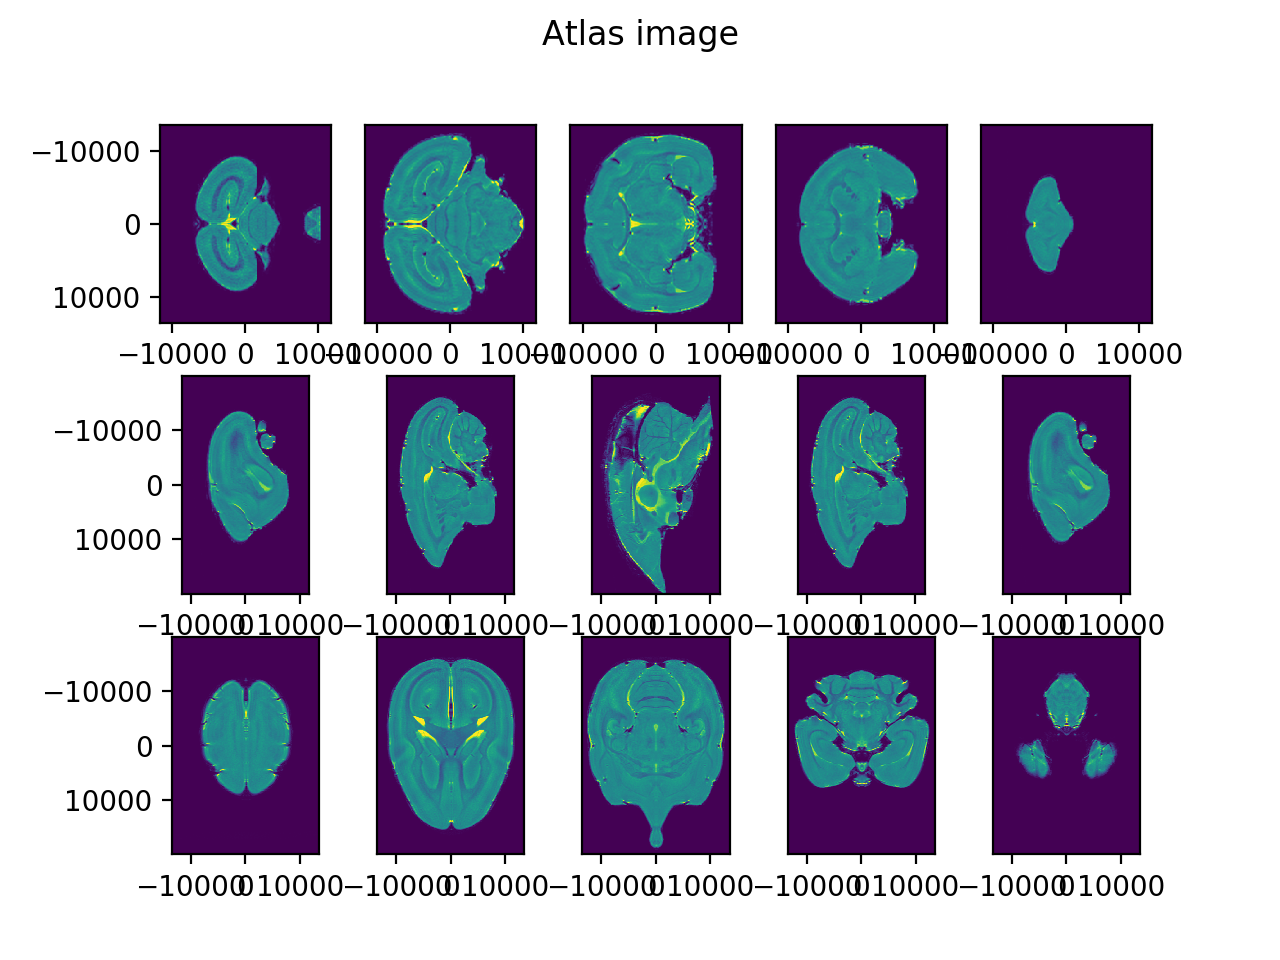

Text(0.5, 0.98, 'Atlas image')

In [65]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

In [66]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[639.9999840000055, 639.9999839999982, 672.0000180000025]


Found extension .nii
Opening with nibabel, note only 3D images supported
[349.99999404 349.99999404 699.99998808]


<IPython.core.display.Javascript object>


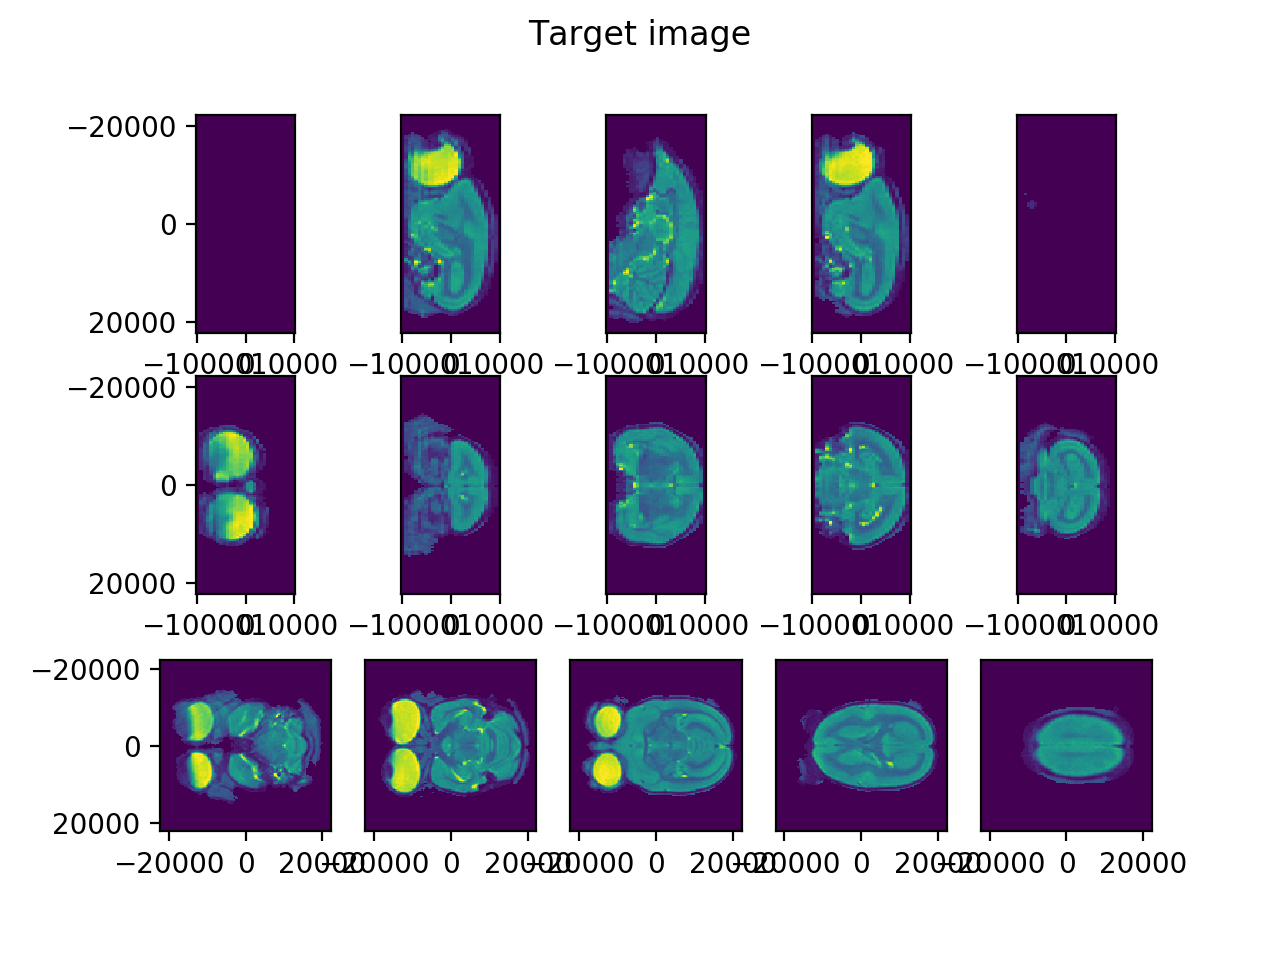

In [67]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x*target_voxel_scale_factor for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
W0 = np.ones_like(J[0])

In [68]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
print(dJ)
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

[699.999988079071, 699.999988079071, 699.999988079071]


<IPython.core.display.Javascript object>


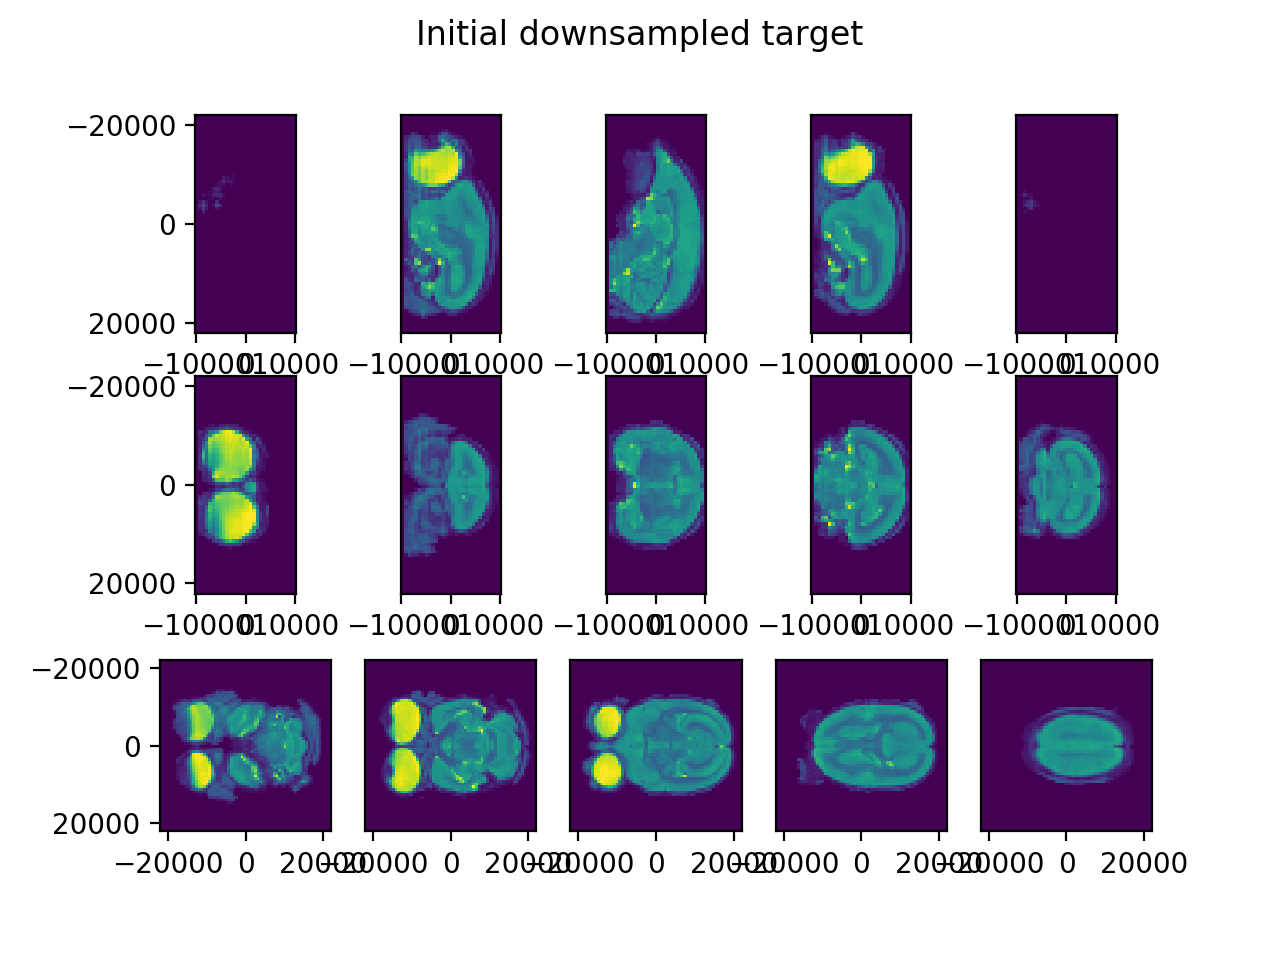

Text(0.5, 0.98, 'Initial downsampled target')

In [69]:
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')

<IPython.core.display.Javascript object>


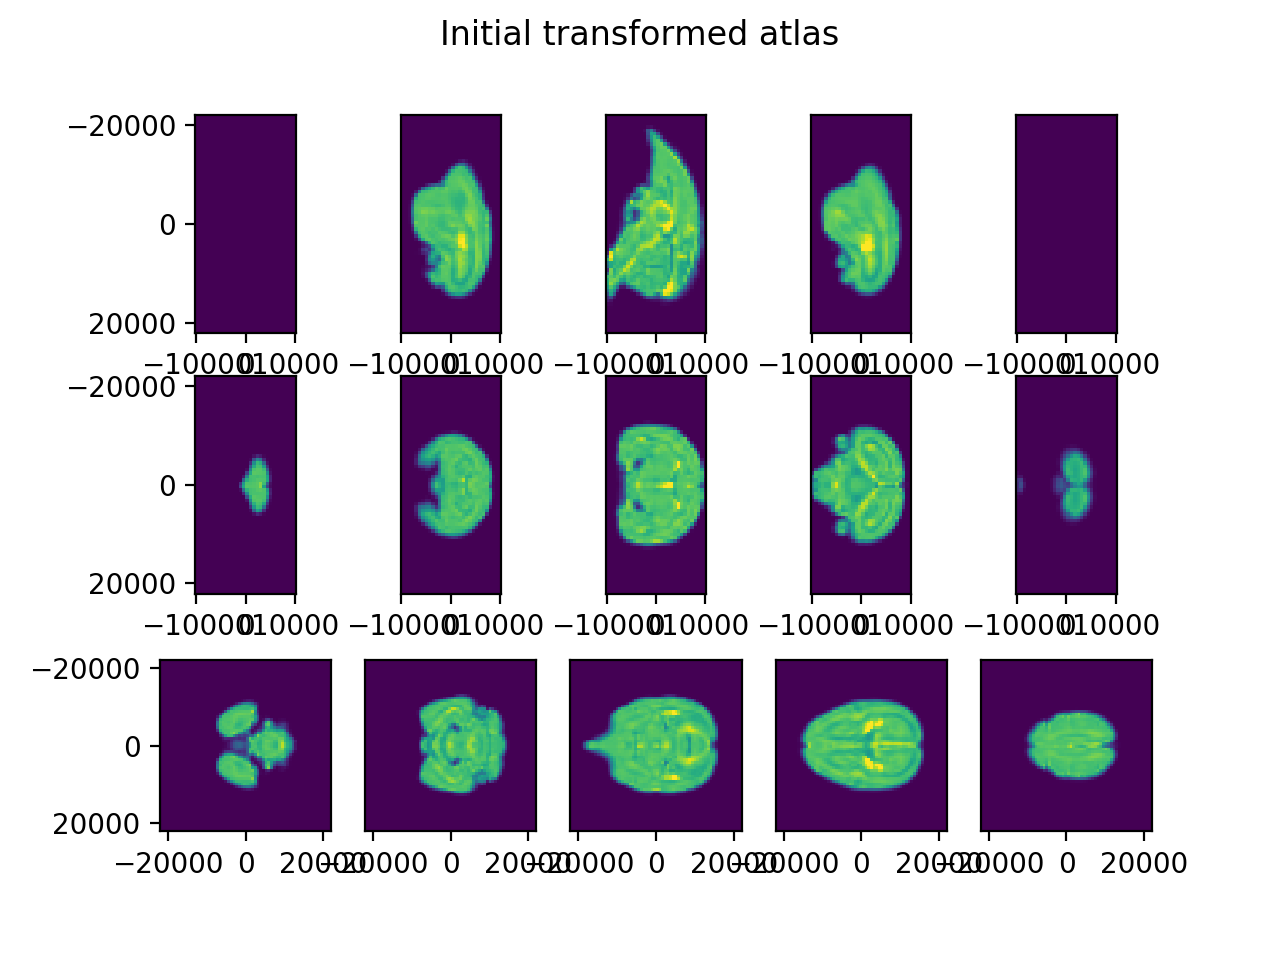

Text(0.5, 0.98, 'Initial transformed atlas')

In [70]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
# this affine (below) is stored in config
#A = np.array([[0,1.0,0.0,0.0],[-1.0,0.0,0.0,0.0],[0.0,0.0,-1.0,0.0],[0.0,0.0,0.0,1.0]])
# this affine matrix should be 4x4, but it may be 1x4x4
while A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

Found 2 scales
dv tensor([1920., 1920., 2016.], device='cuda:0')
a scale is 3840.0


<IPython.core.display.Javascript object>


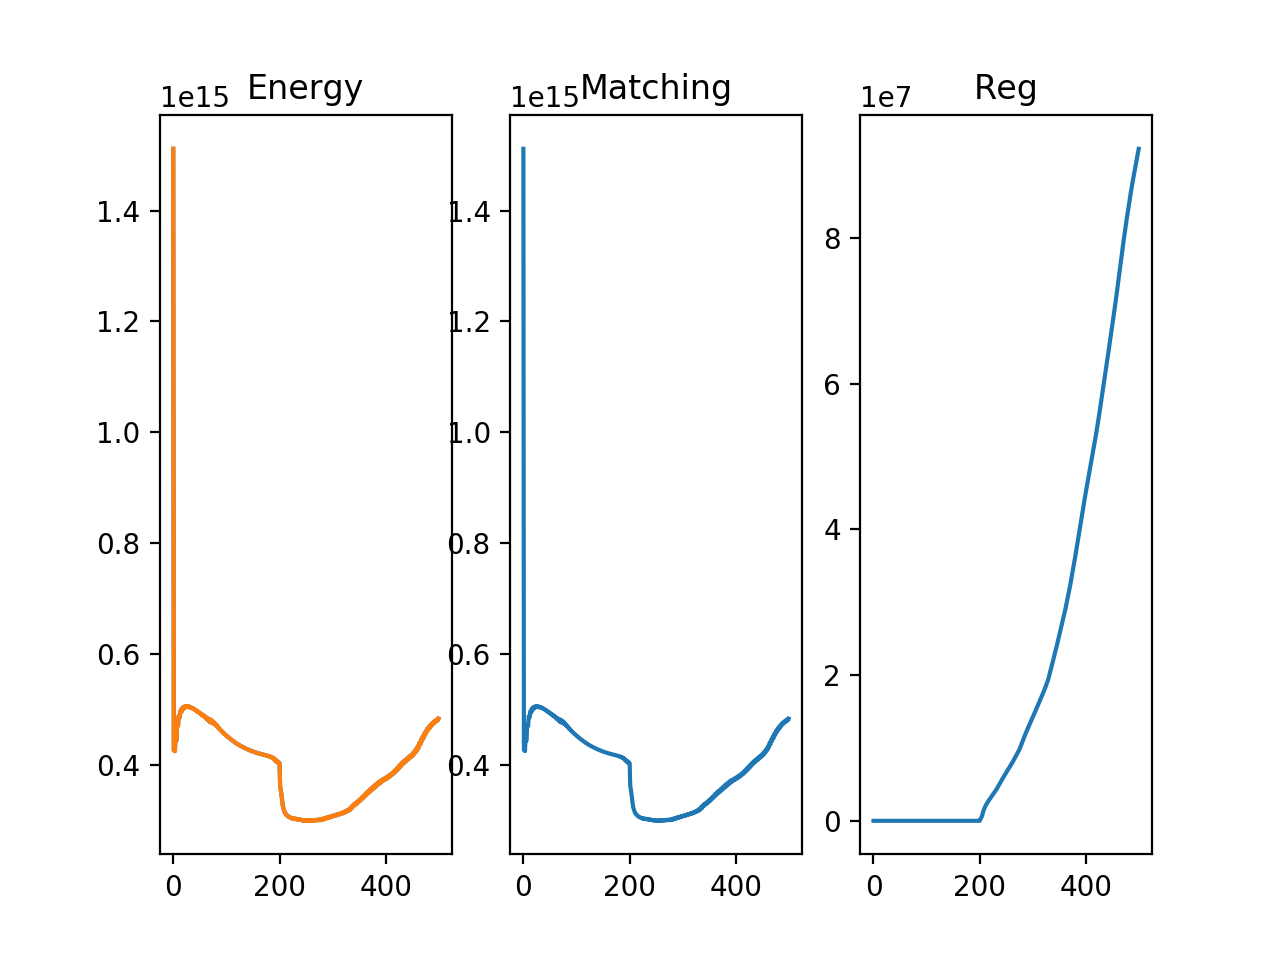

<IPython.core.display.Javascript object>


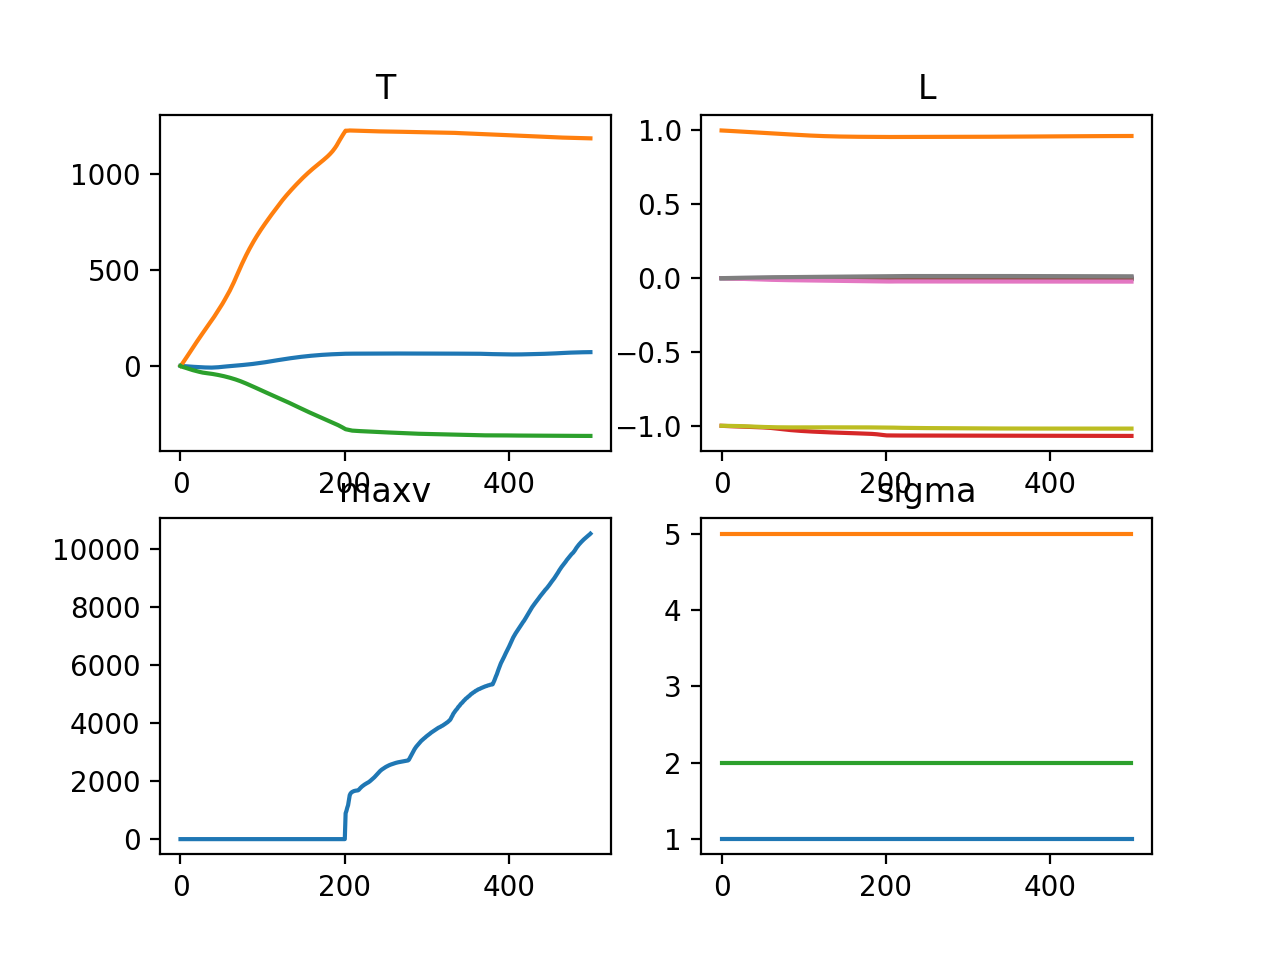

<IPython.core.display.Javascript object>


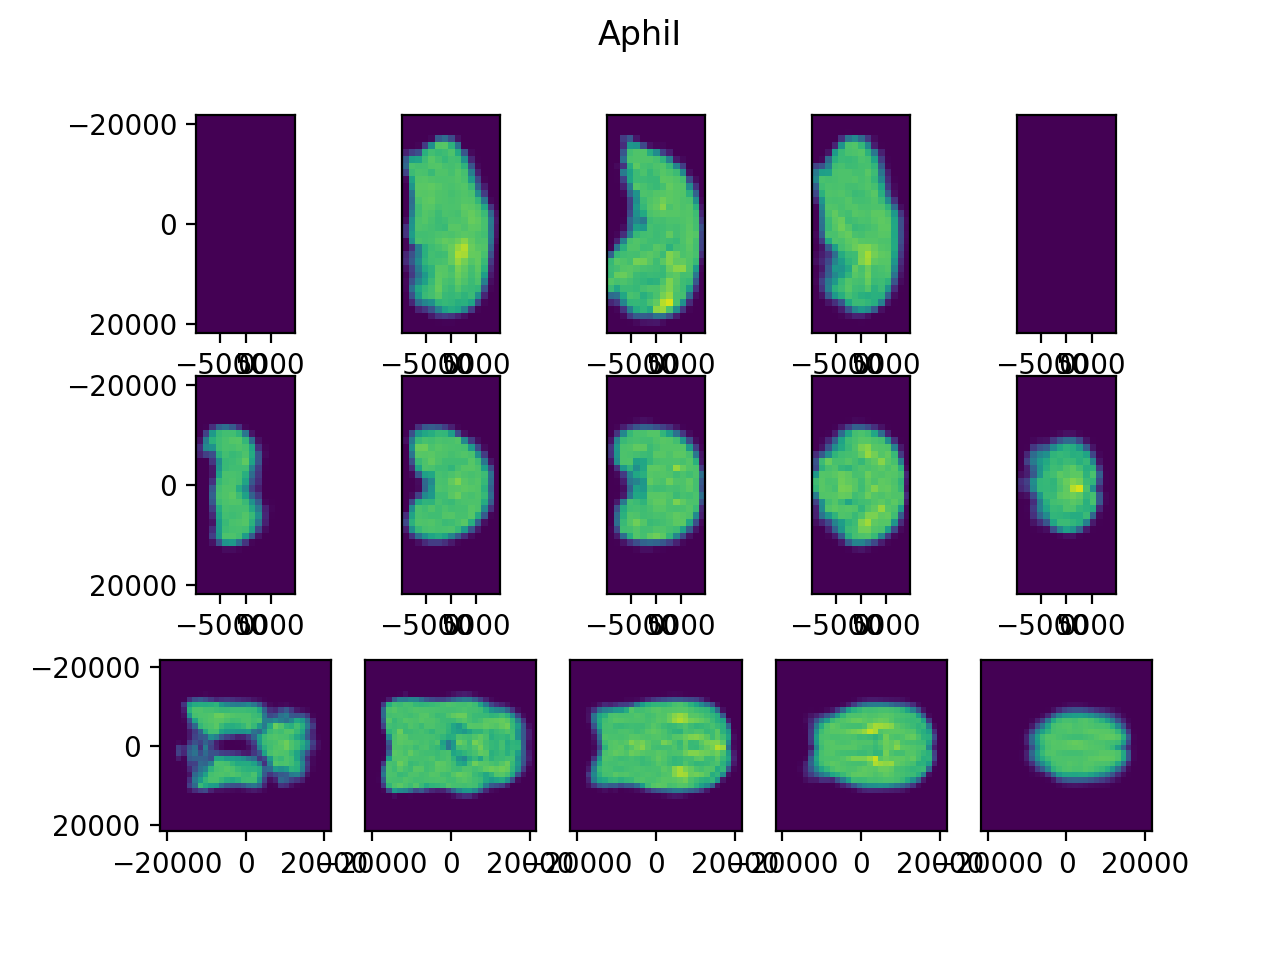

<IPython.core.display.Javascript object>


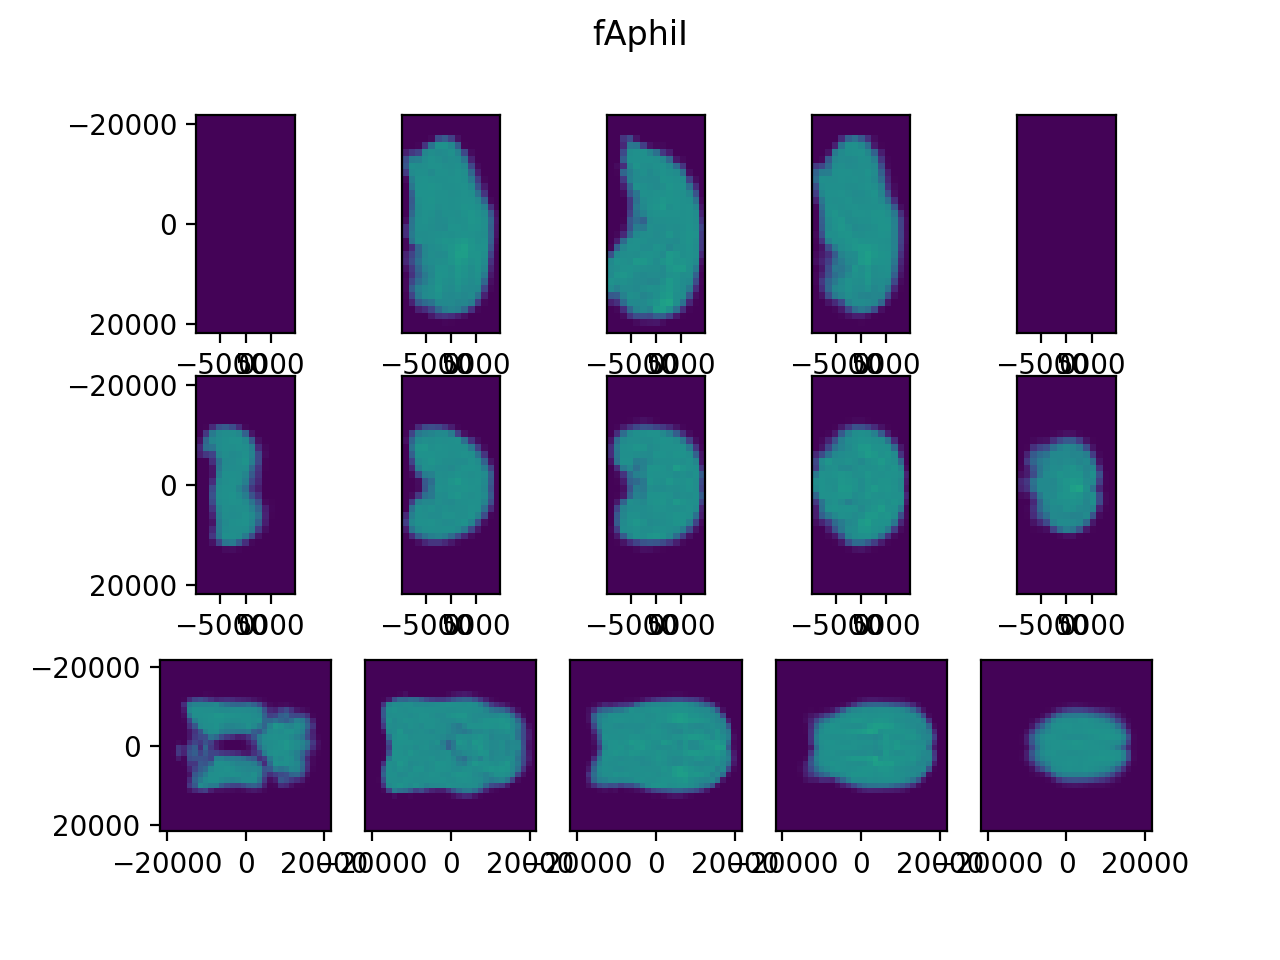

<IPython.core.display.Javascript object>


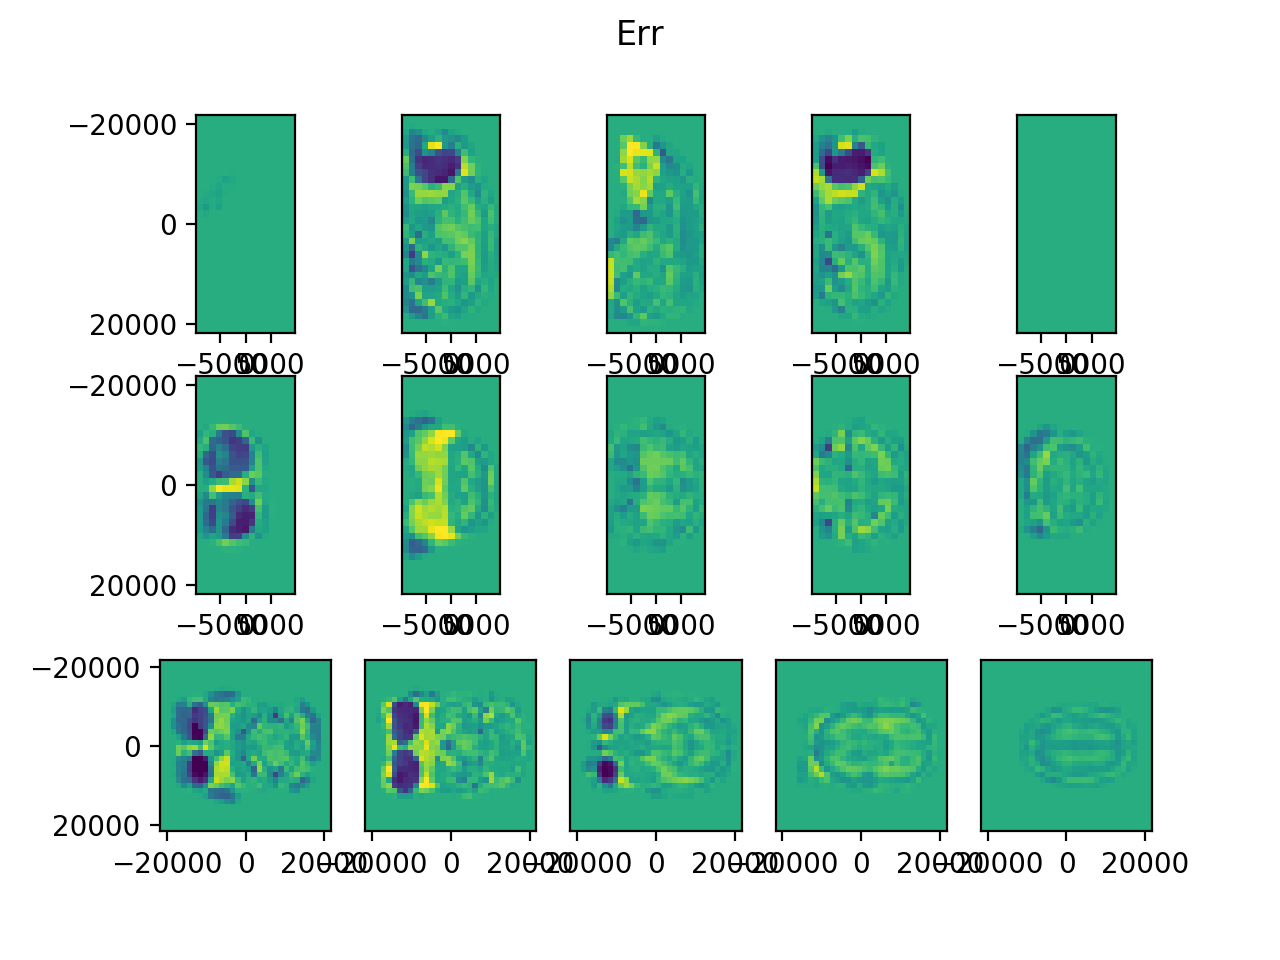

<IPython.core.display.Javascript object>


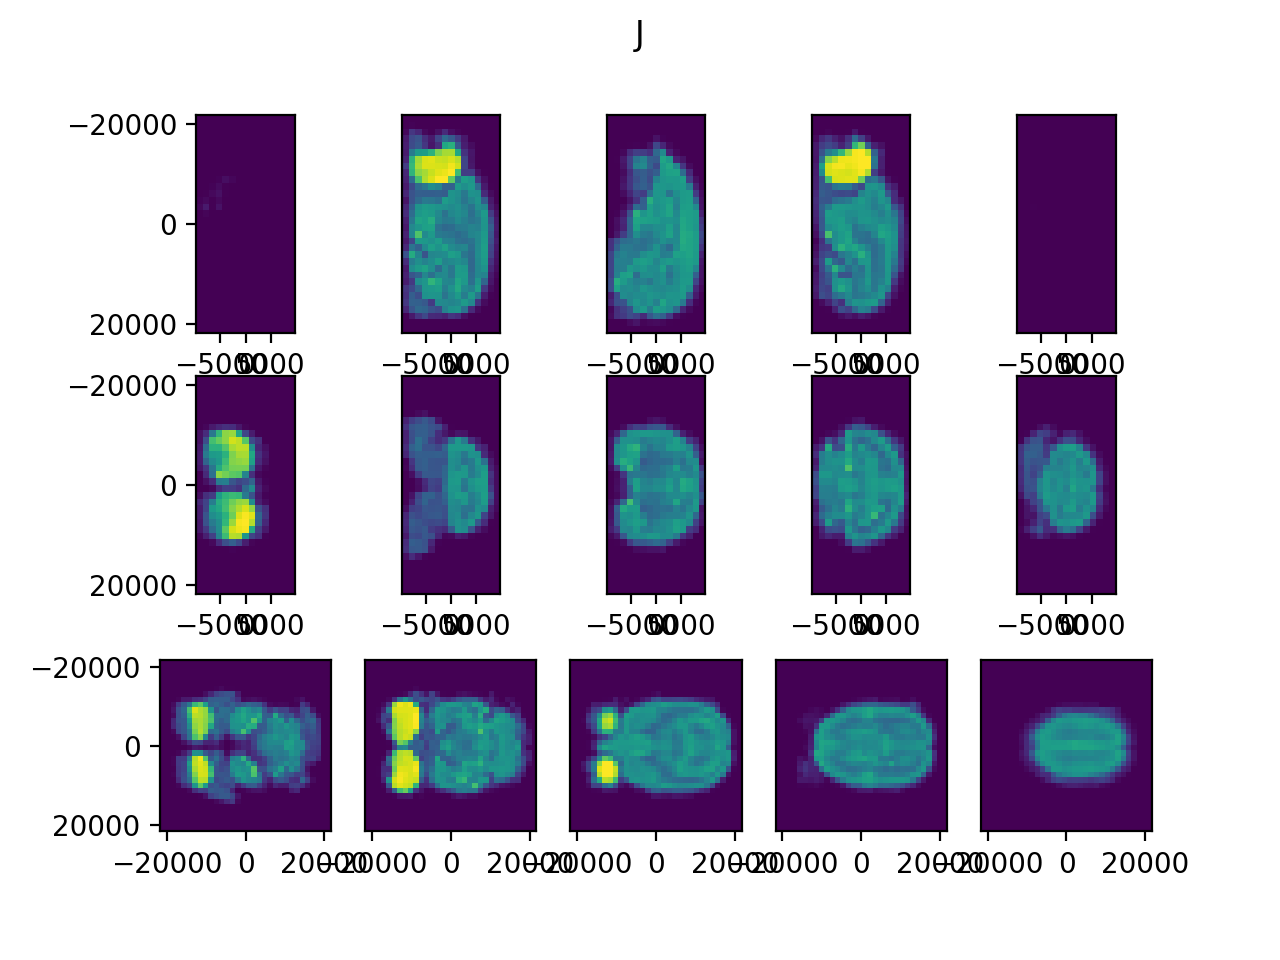

<IPython.core.display.Javascript object>


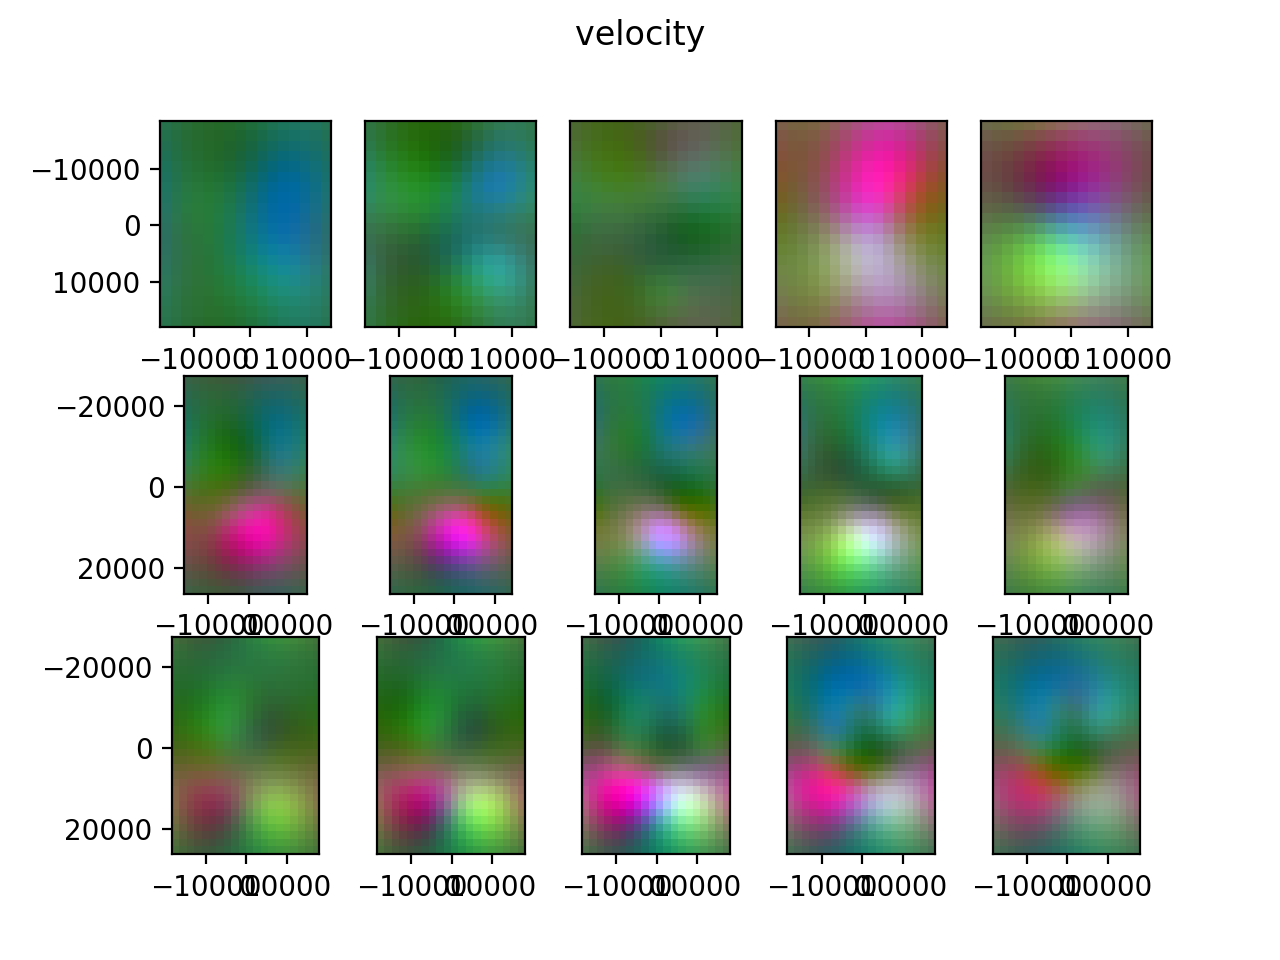

<IPython.core.display.Javascript object>


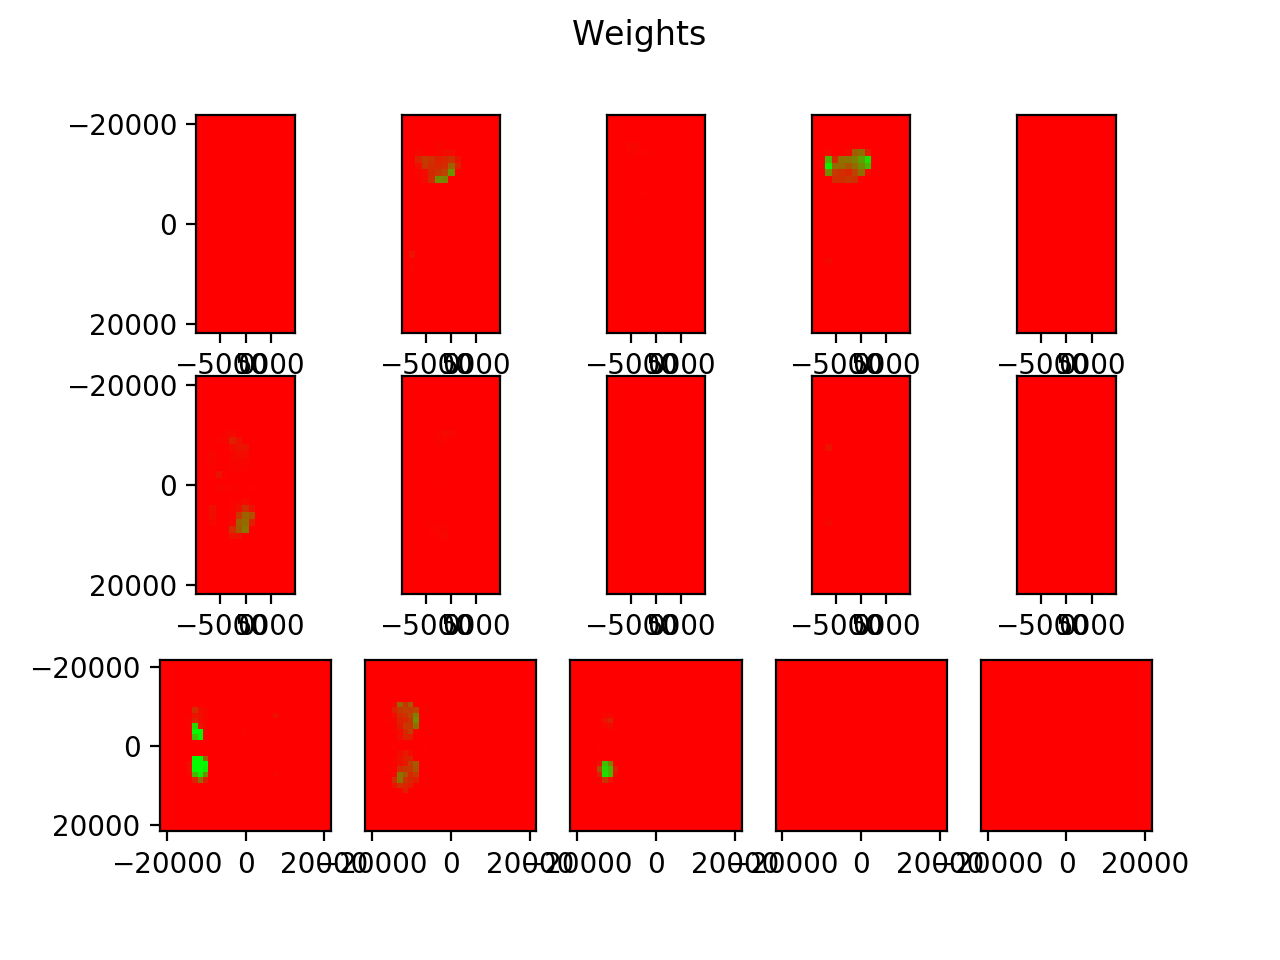

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Finished iteration 200
Finished iteration 210
Finished iteration 220
Iteration 230, translation oscilating, reducing eA to 90000.0
Finished iteration 230
Finished iteration 240
Finished iteration 250
Finished iteration 260
Finished iteration 270
Finished iteration 280
Finished iteration 290
Finished iteration 300
Finished iteration 310
Iteration 320, linear oscilating, reducing eA to 81000.0
Finished iteration 320
Finished iteration 330
Finished iteration 340
Iteration 350, translation oscilating, reducing eA to 72900.0
Finished iteration 350
Fi

<IPython.core.display.Javascript object>


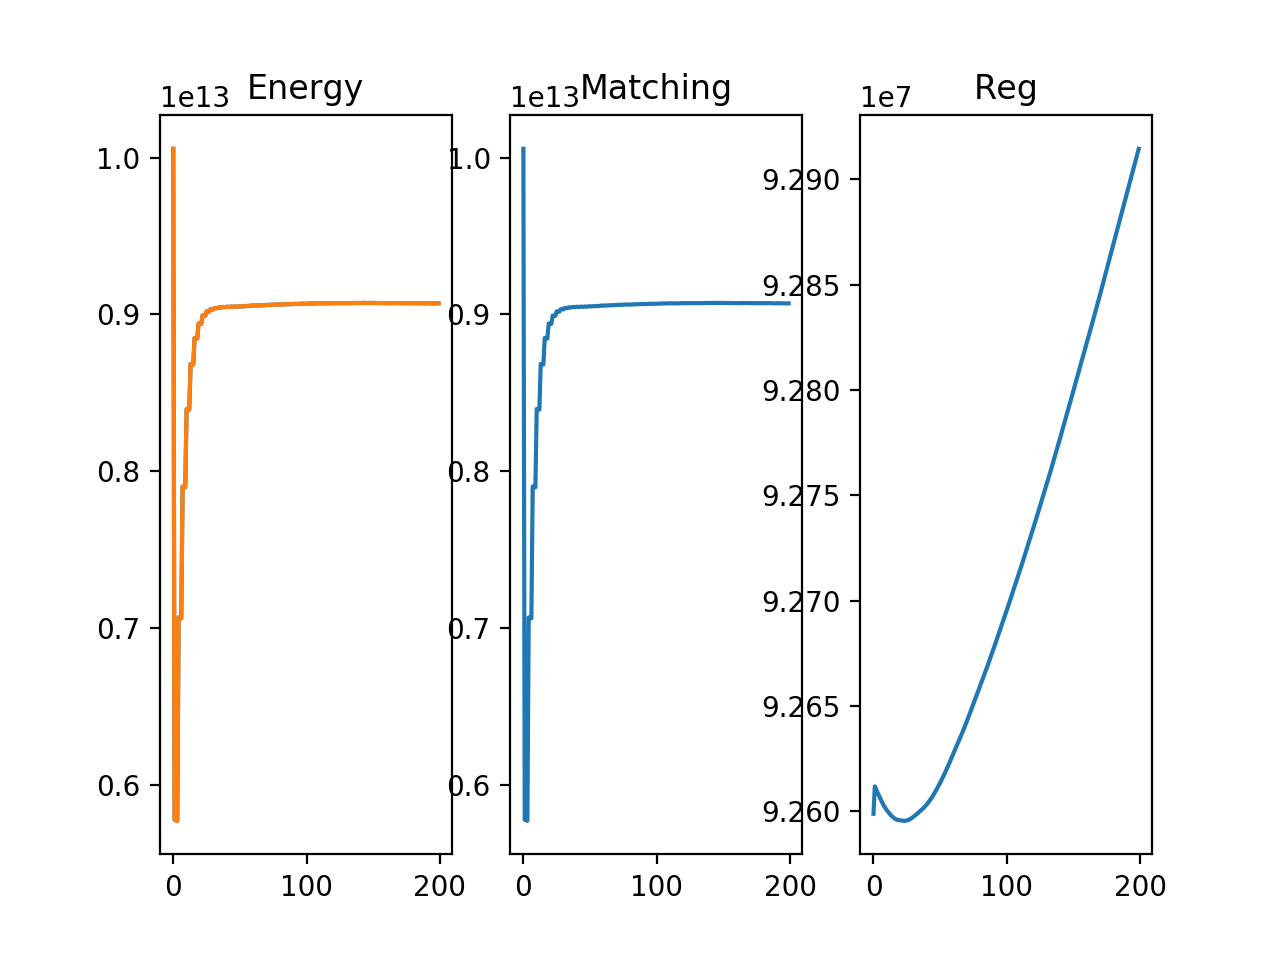

<IPython.core.display.Javascript object>


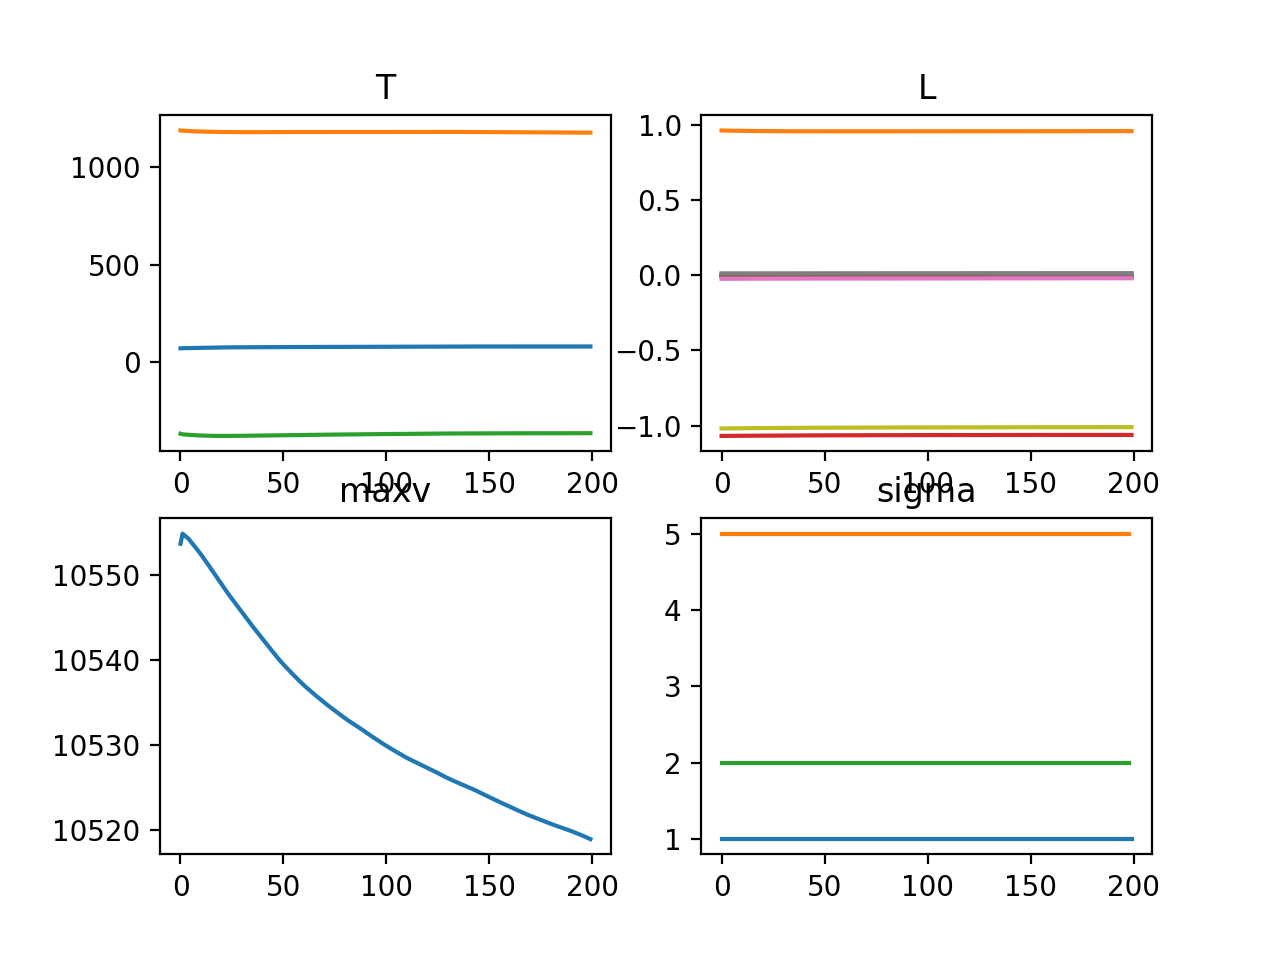

<IPython.core.display.Javascript object>


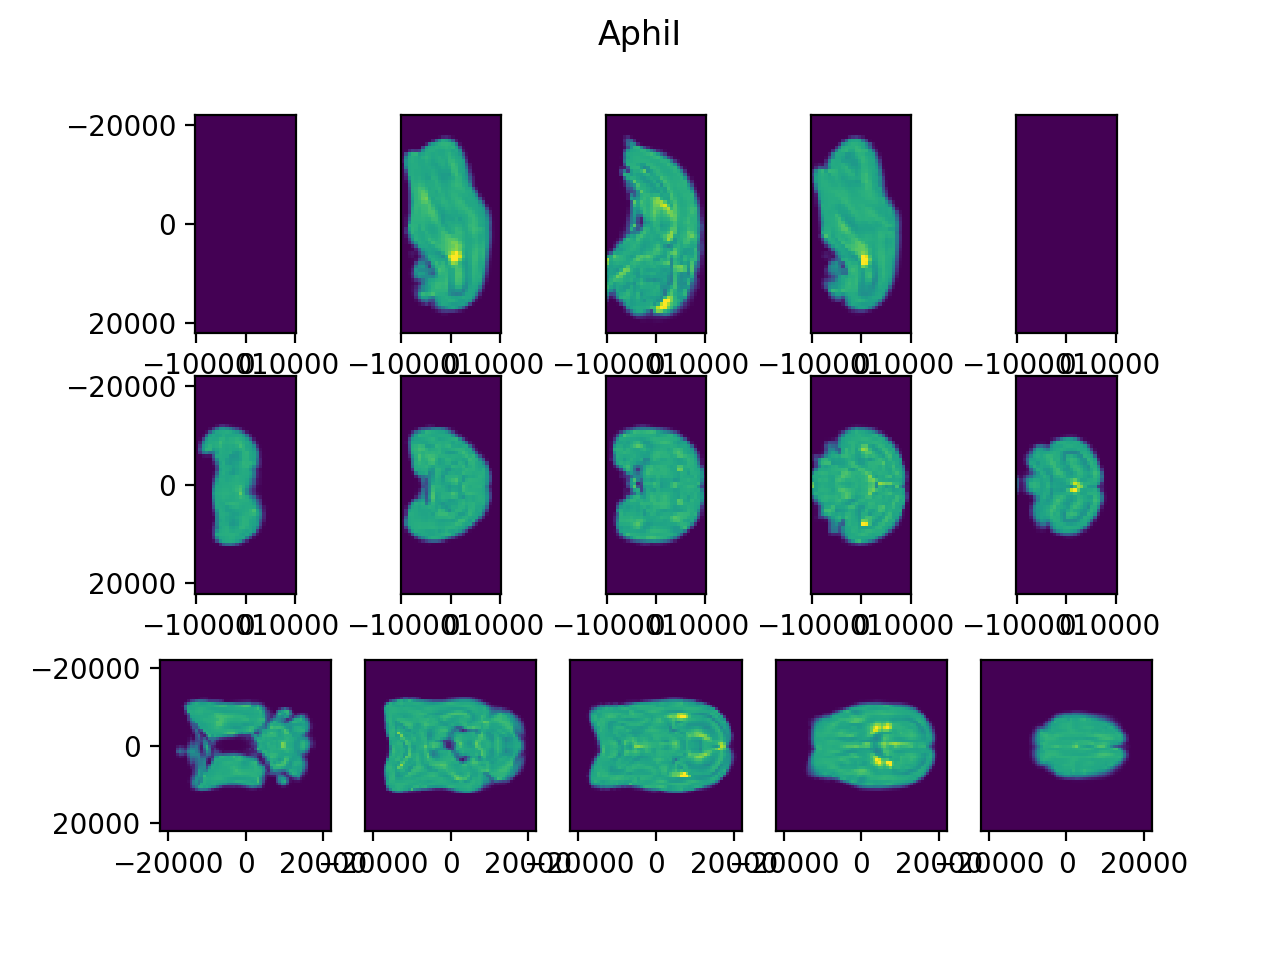

<IPython.core.display.Javascript object>


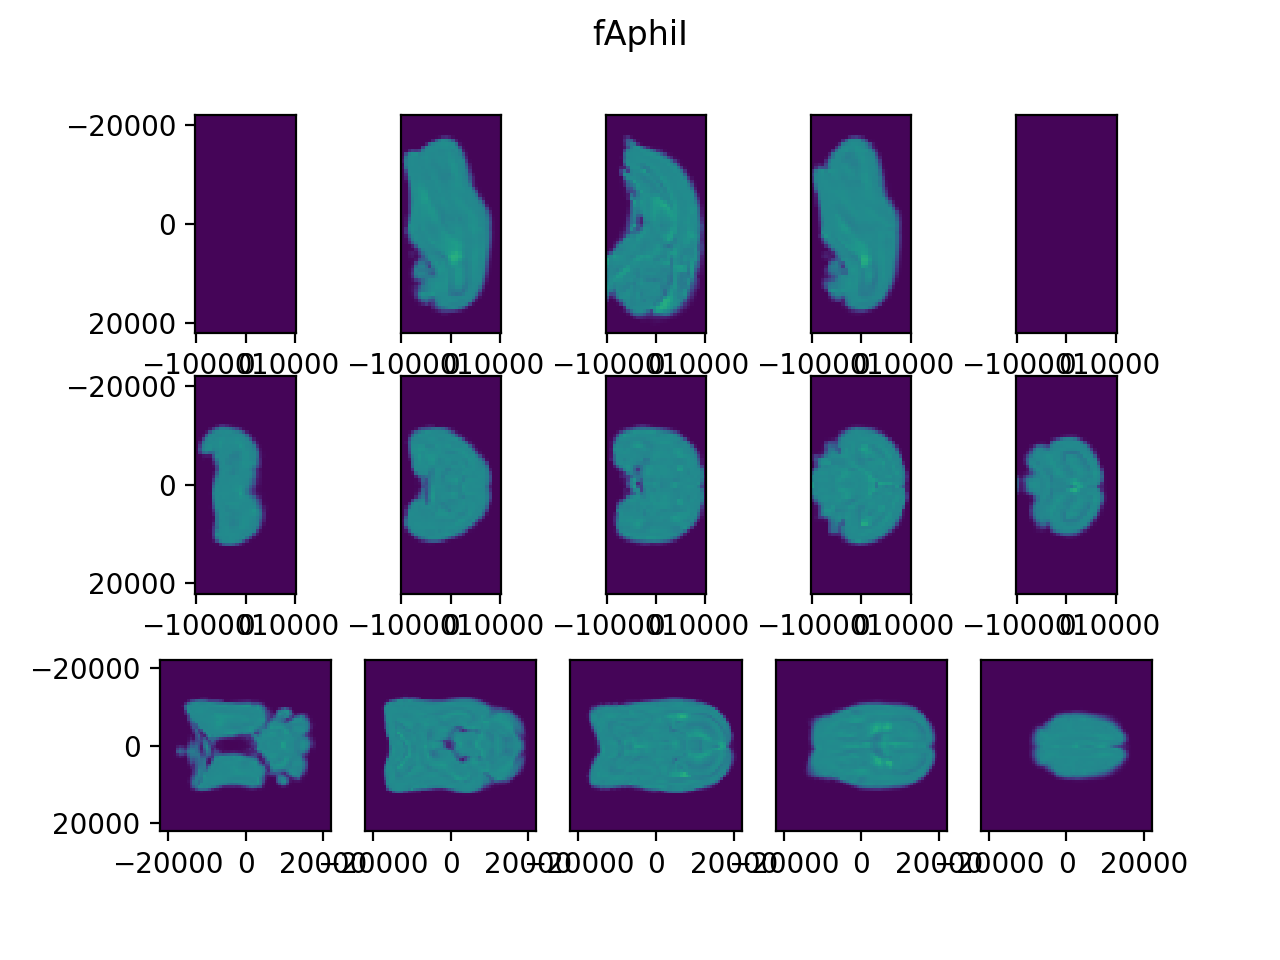

<IPython.core.display.Javascript object>


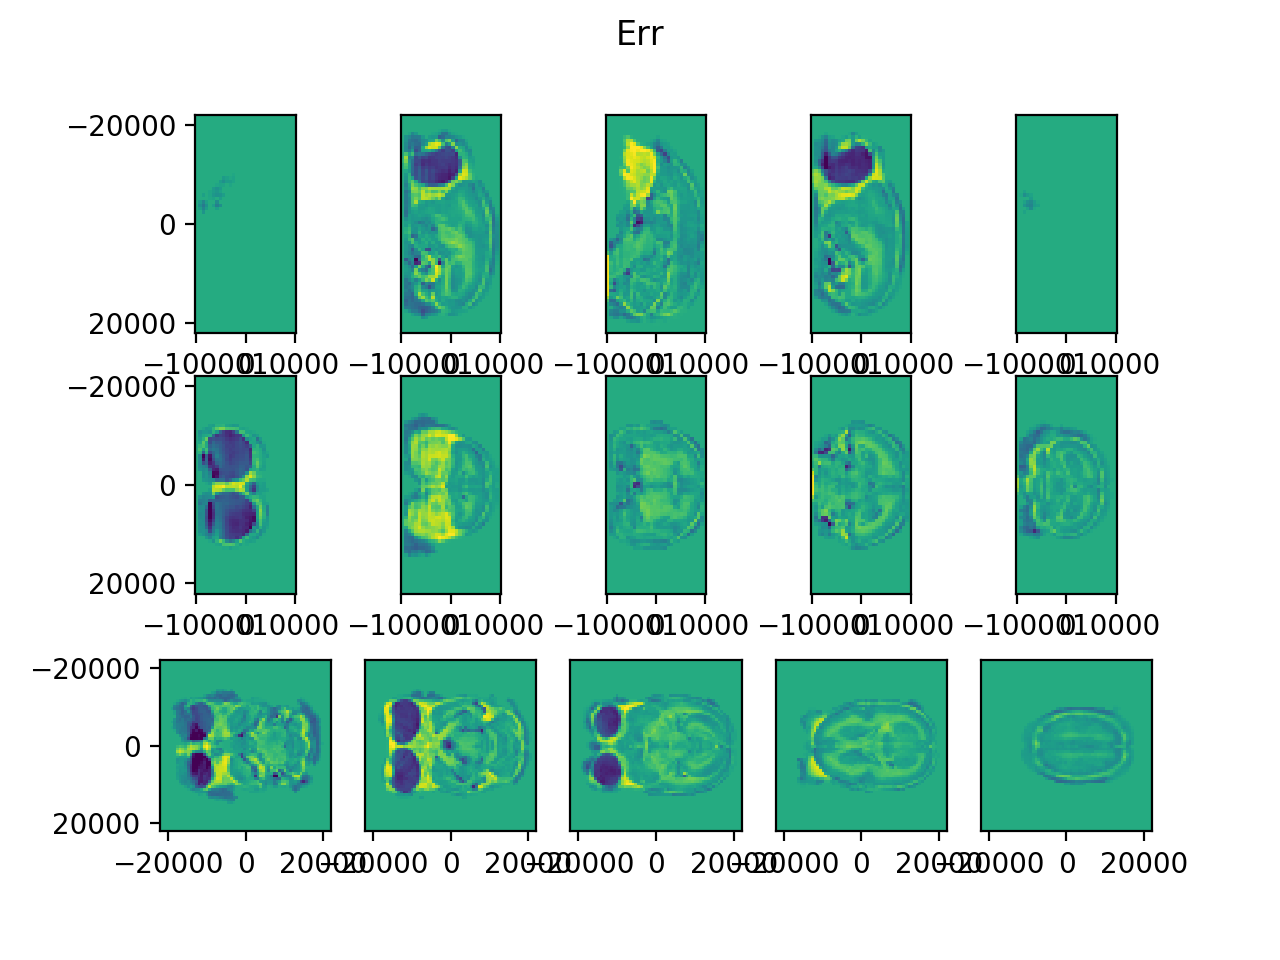

<IPython.core.display.Javascript object>


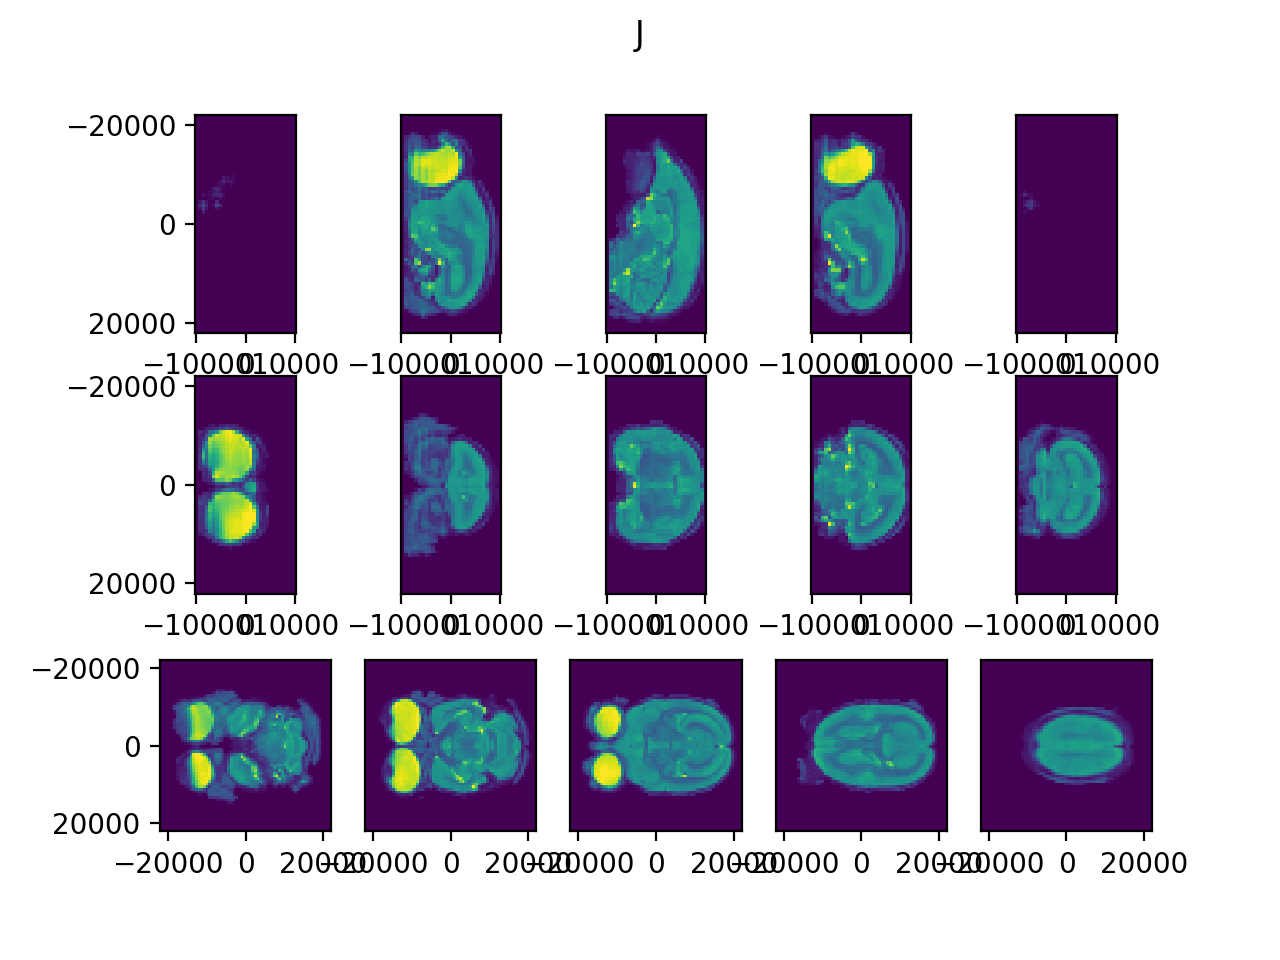

<IPython.core.display.Javascript object>


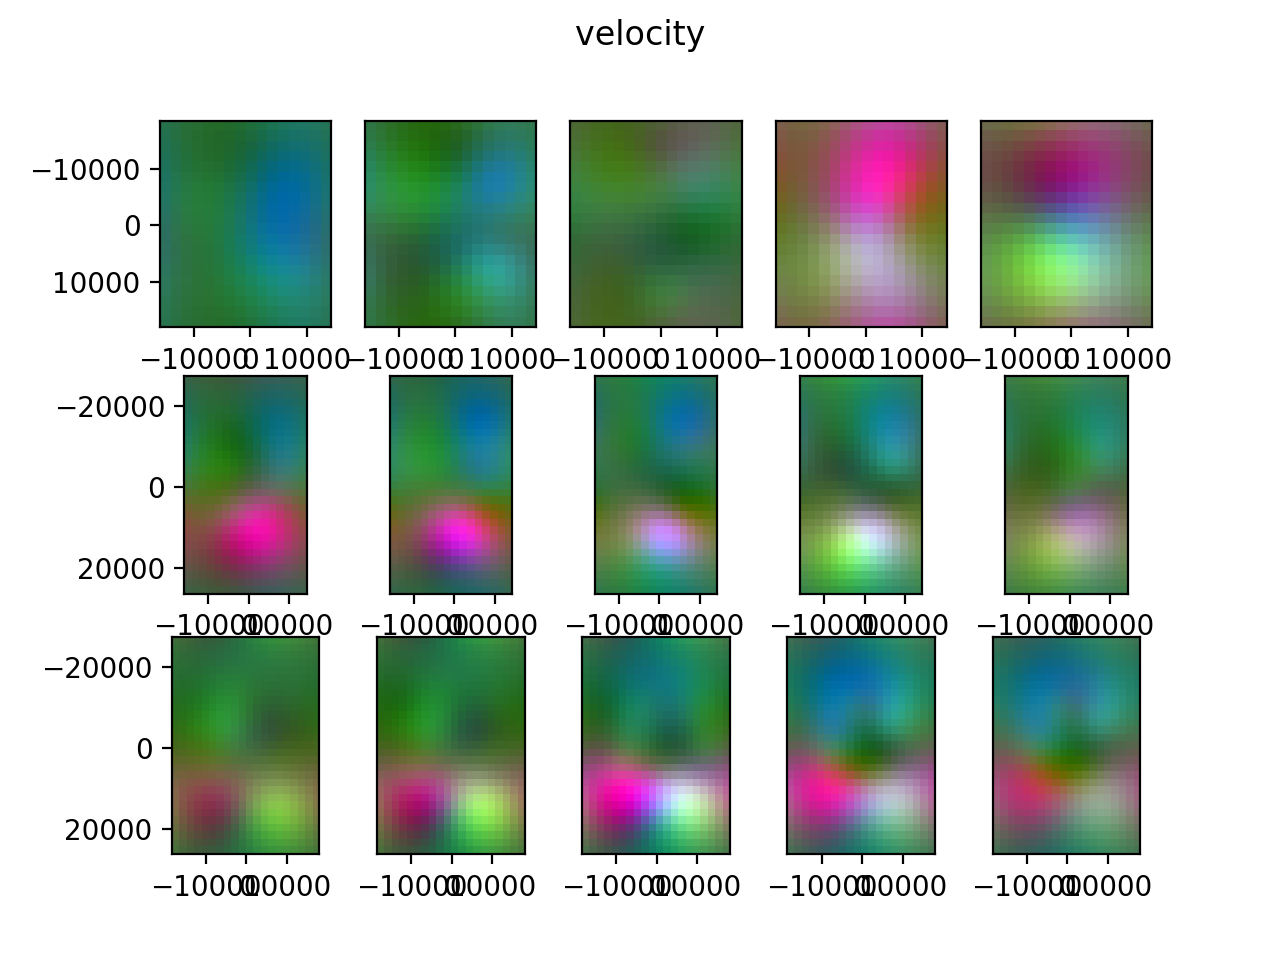

<IPython.core.display.Javascript object>


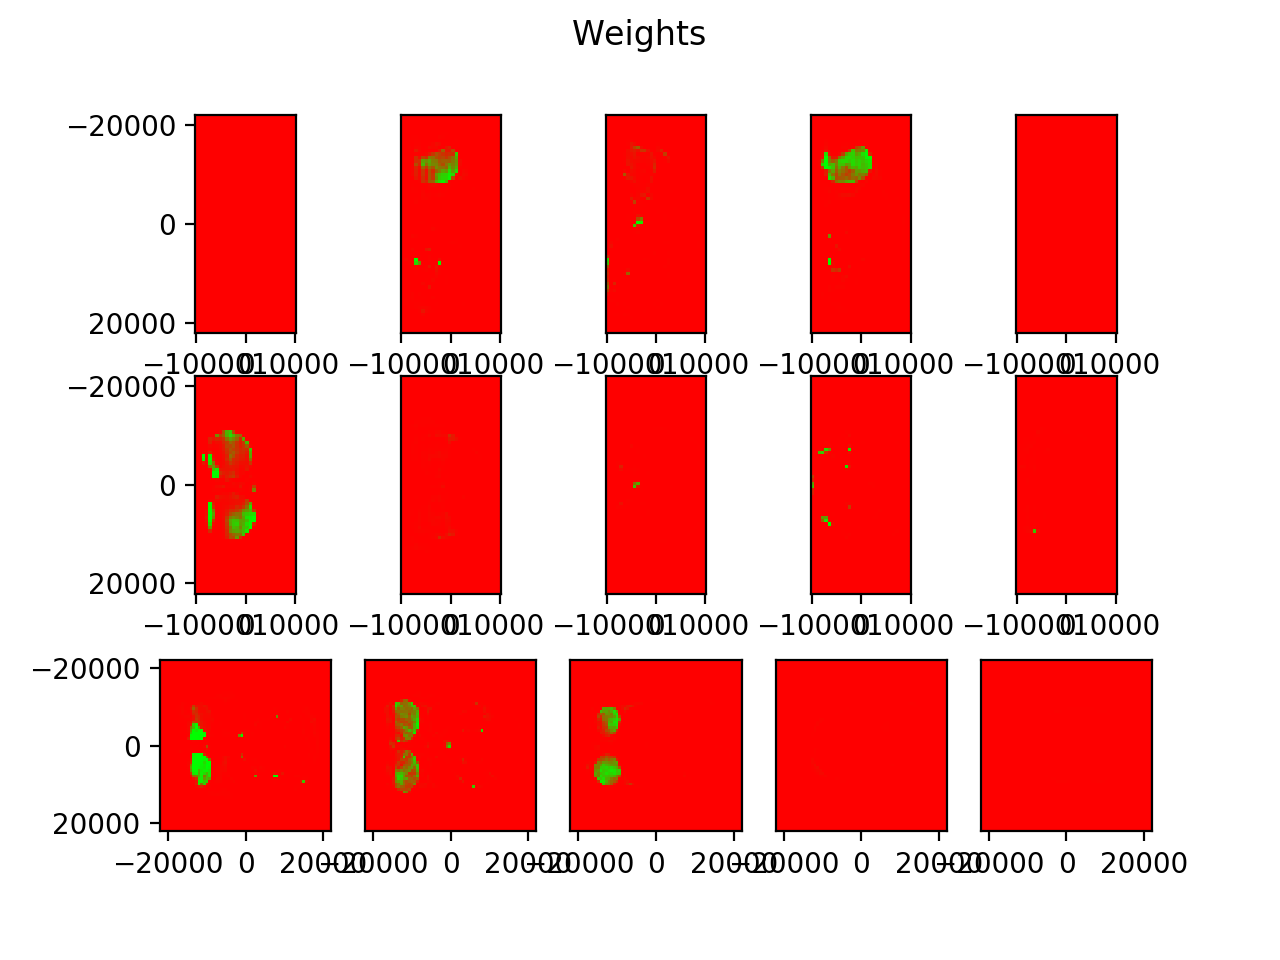

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Iteration 190, translation oscilating, reducing eA to 90000.0
Finished iteration 190


In [71]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [72]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

In [77]:
# get labels
xS,S,title,names = emlddmm.read_data(label_name,endian='l')

Found extension .vtk


cpu
output dir is ricardo_nii_test/qc/


<IPython.core.display.Javascript object>


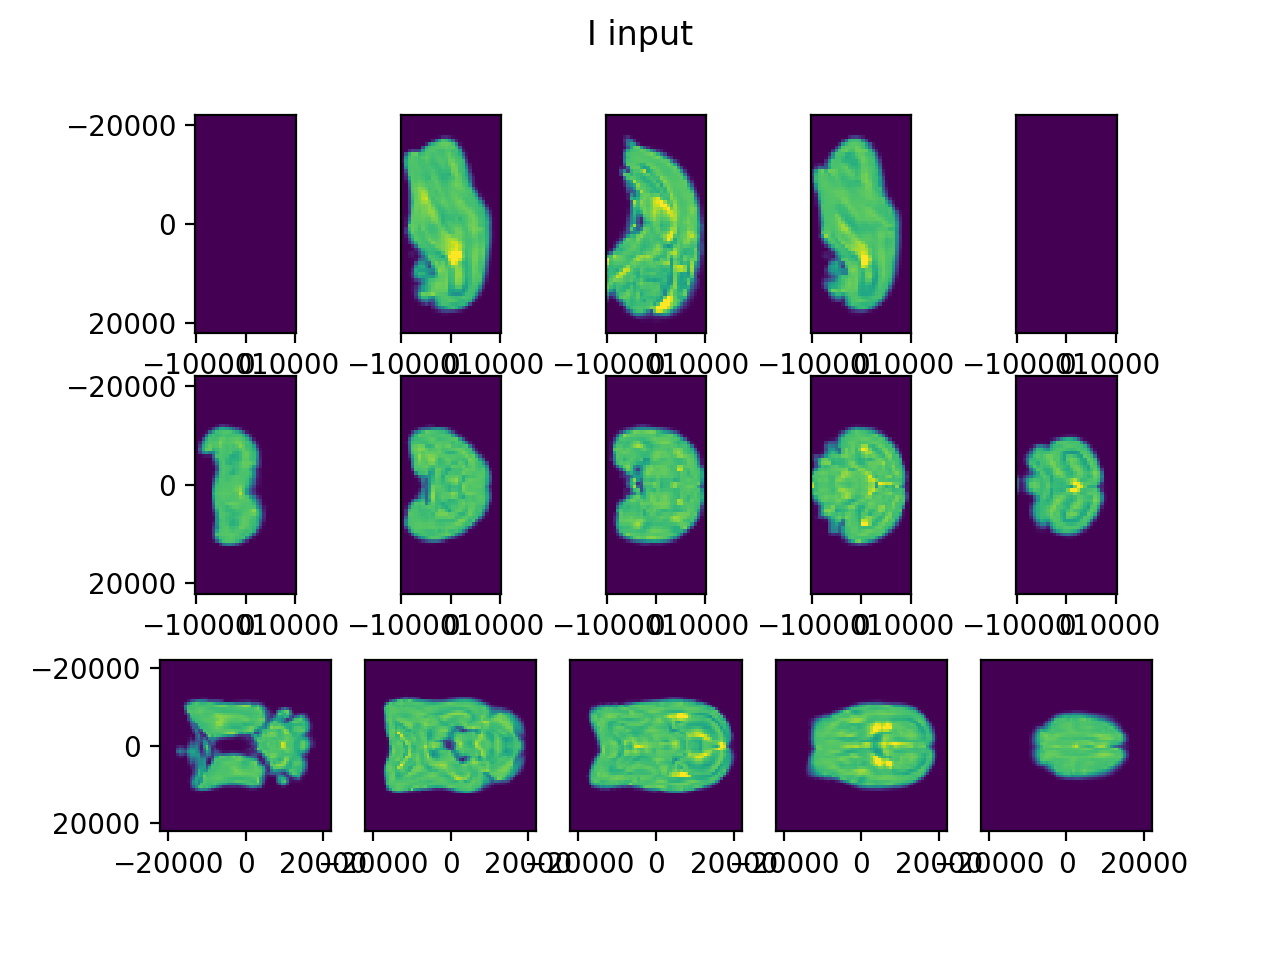

<IPython.core.display.Javascript object>


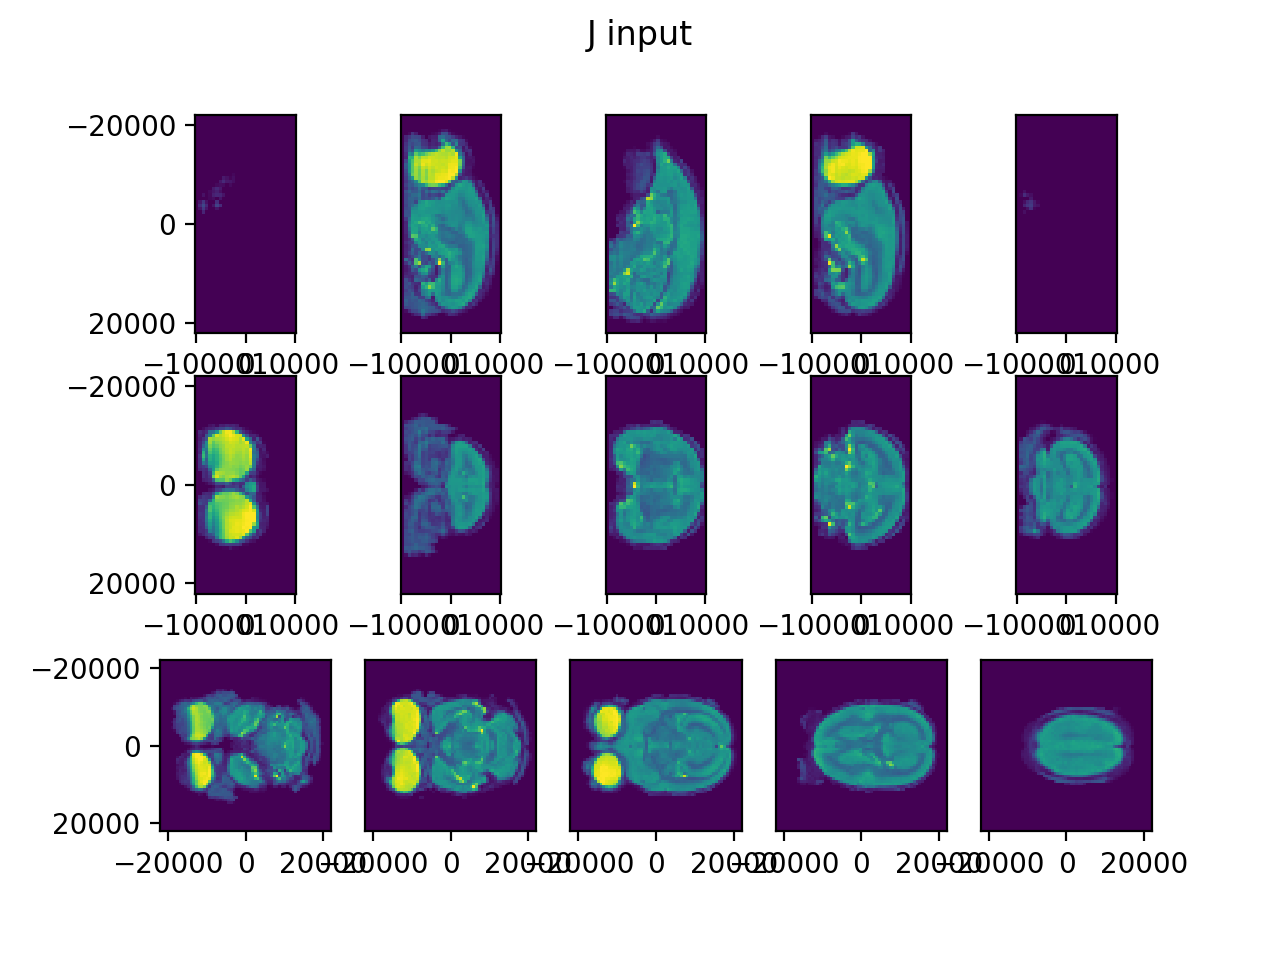

<IPython.core.display.Javascript object>


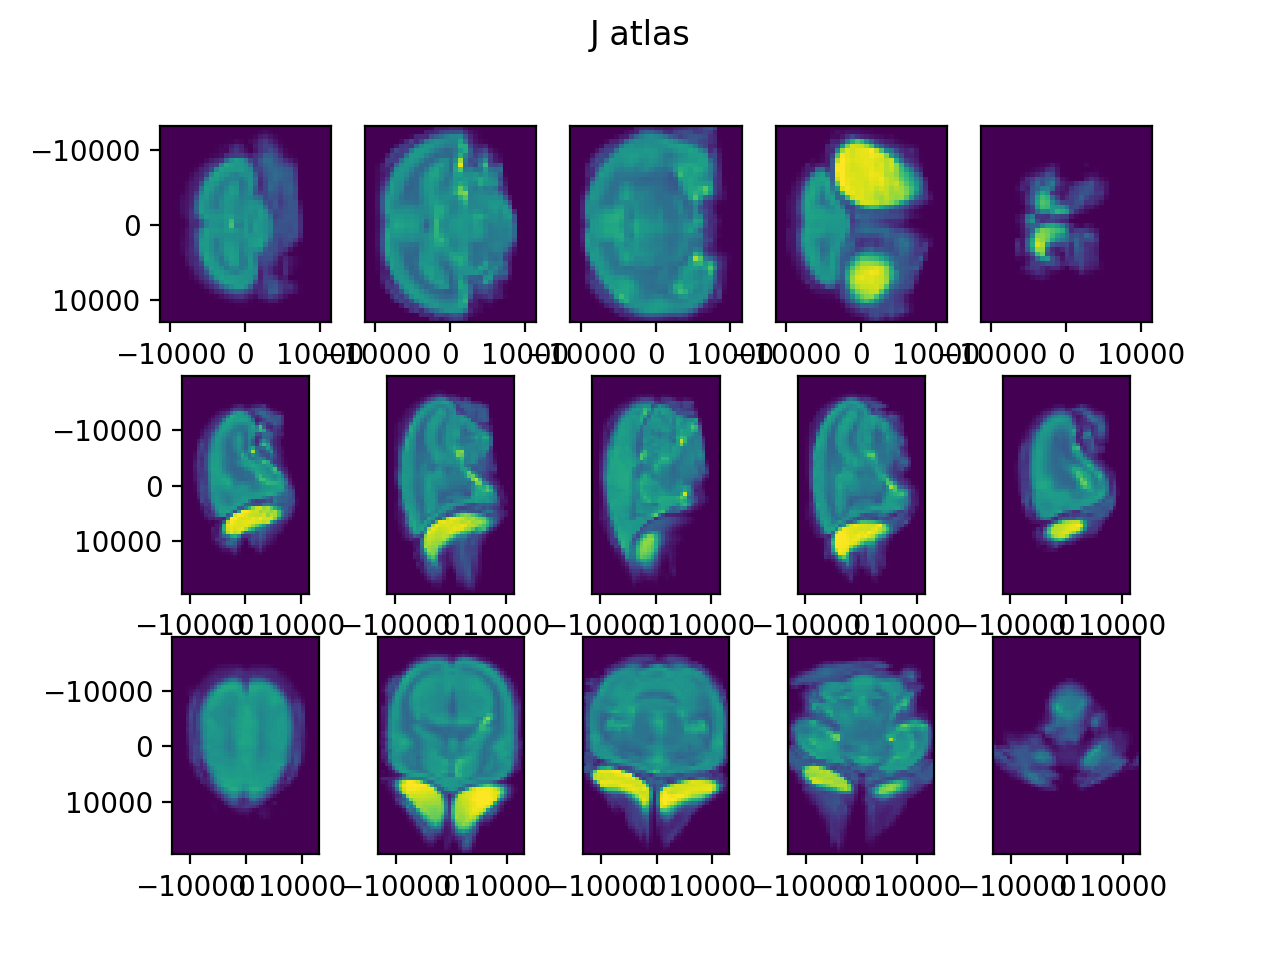

<IPython.core.display.Javascript object>


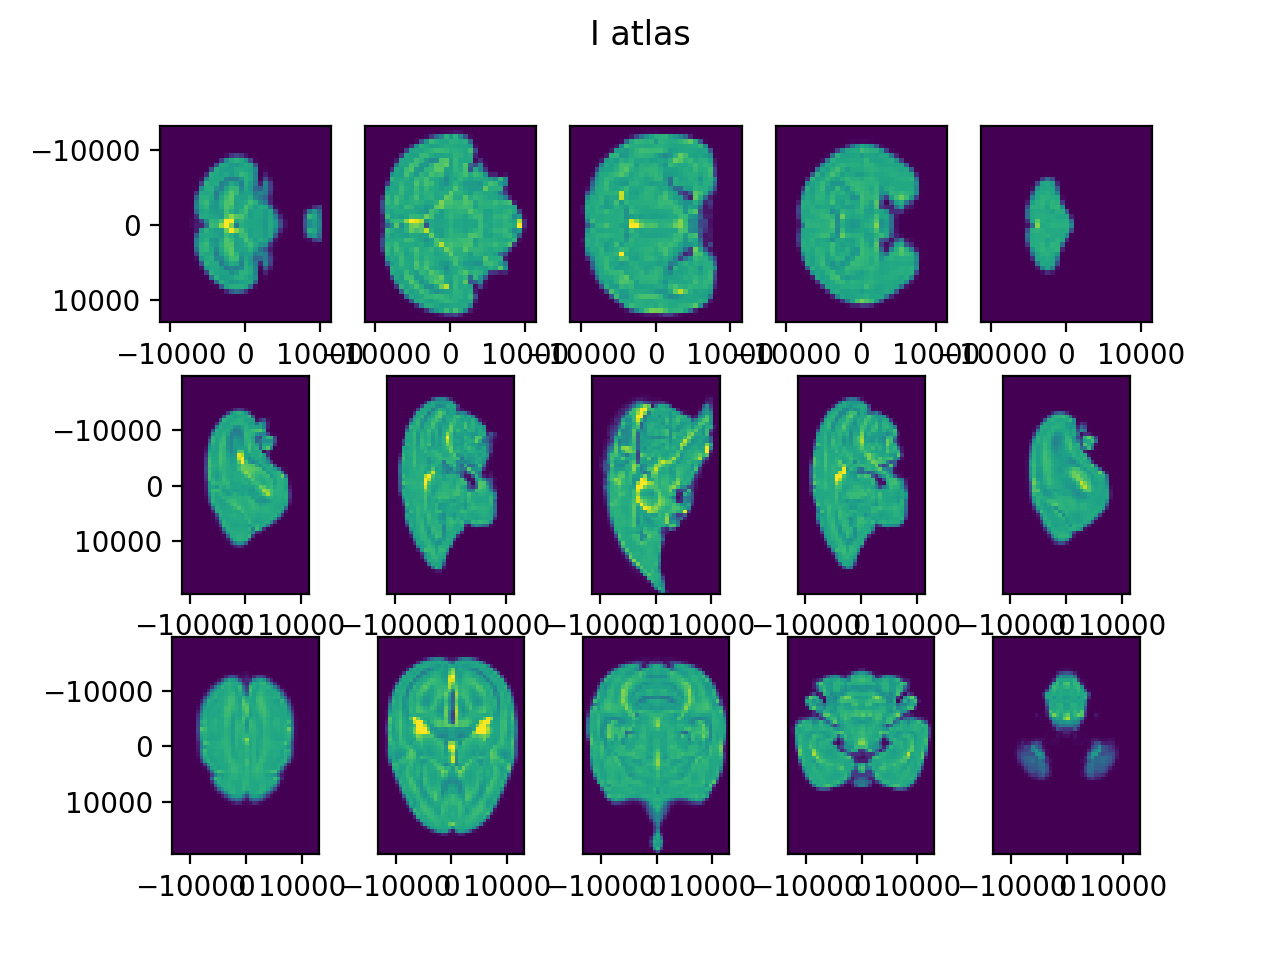

In [78]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [79]:
# apply forward transform (target image to atlas)
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


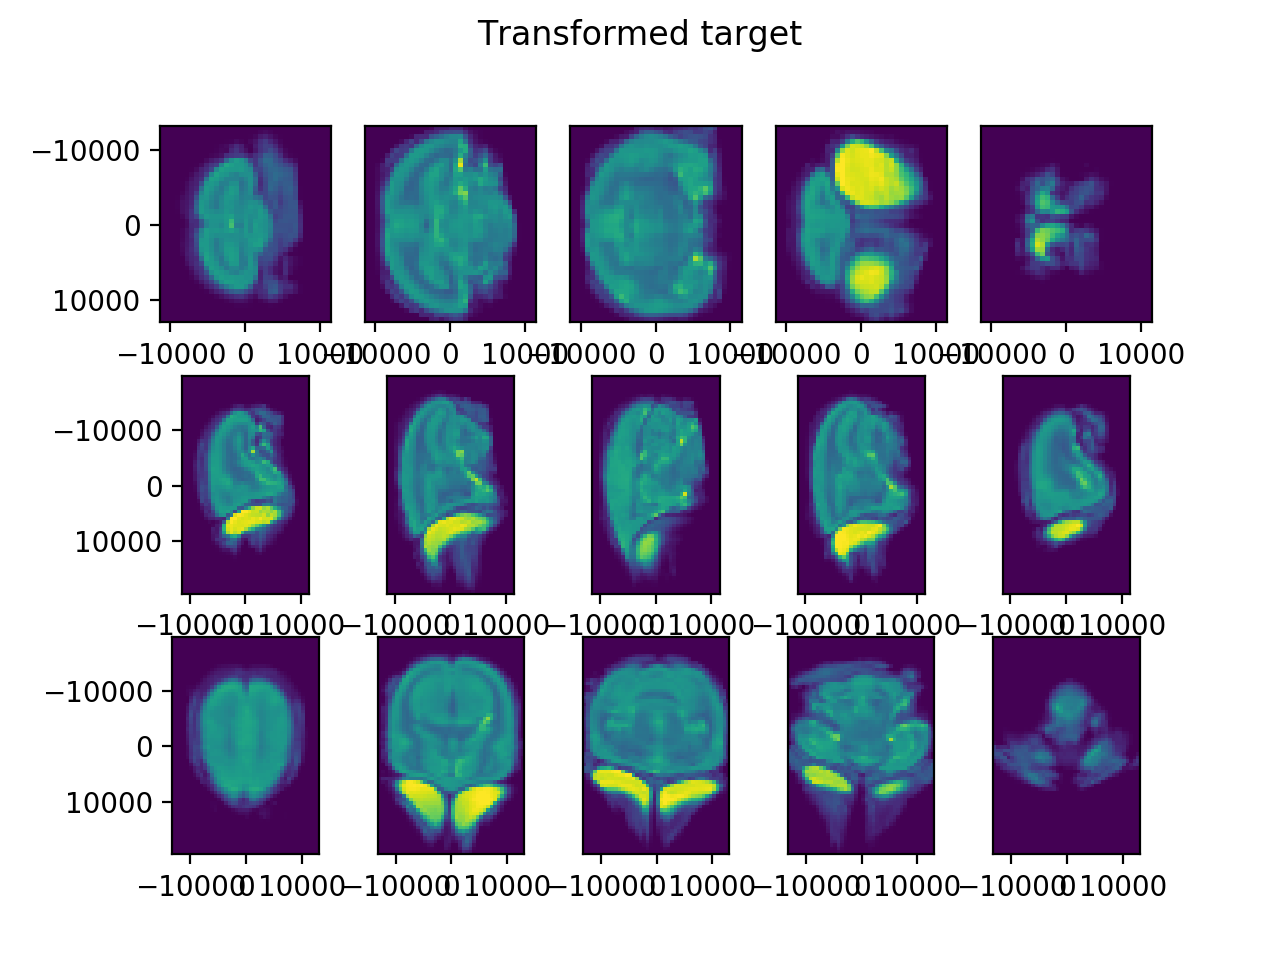

Text(0.5, 0.98, 'Transformed target')

In [80]:
emlddmm.draw(Jt,xI)
plt.gcf().suptitle('Transformed target')

In [81]:
# apply backward transform (atlas images to target)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)
St = emlddmm.apply_transform_int(xS,S,Xout)

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


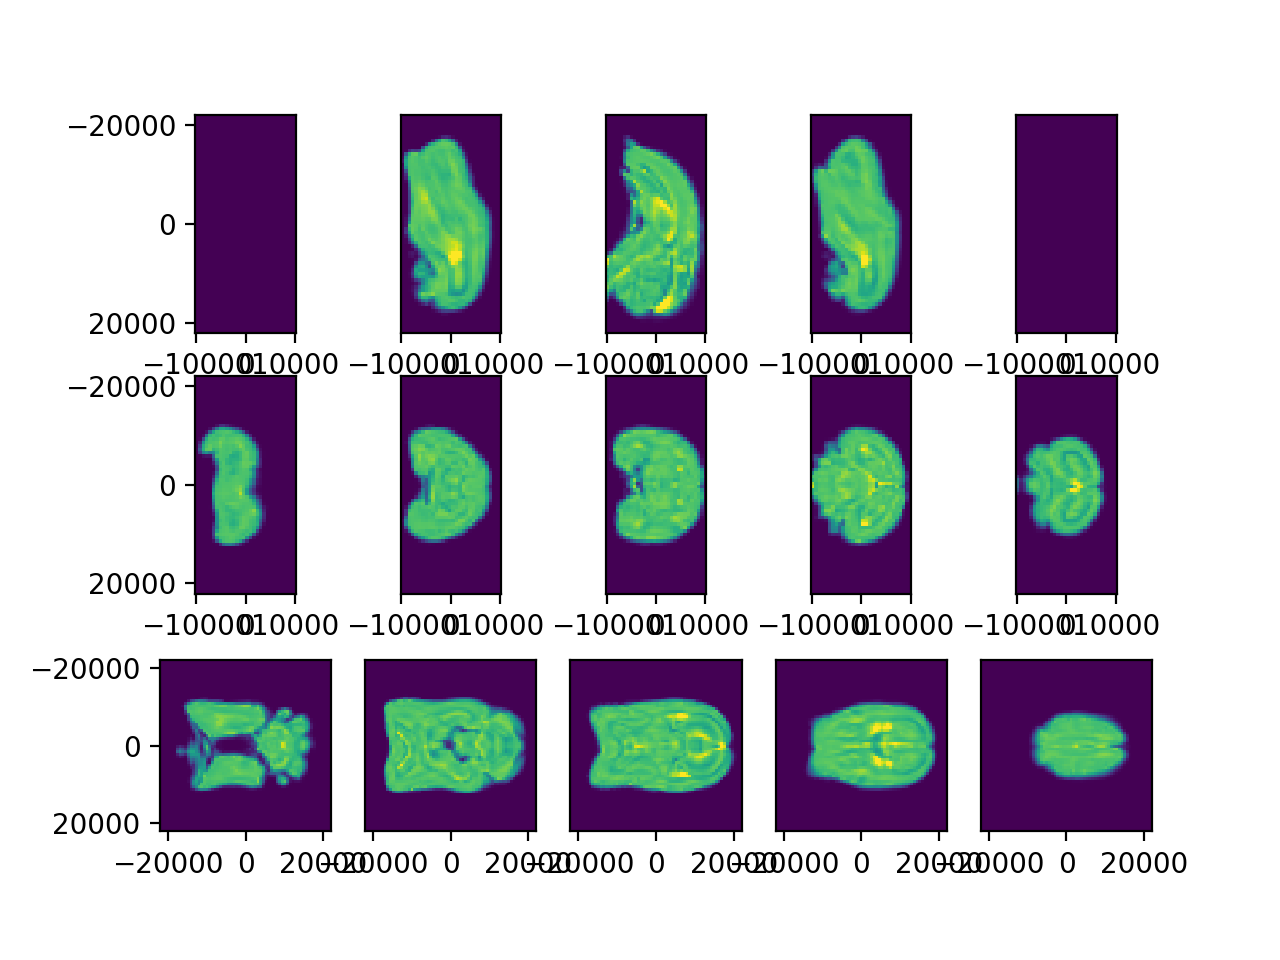

<IPython.core.display.Javascript object>


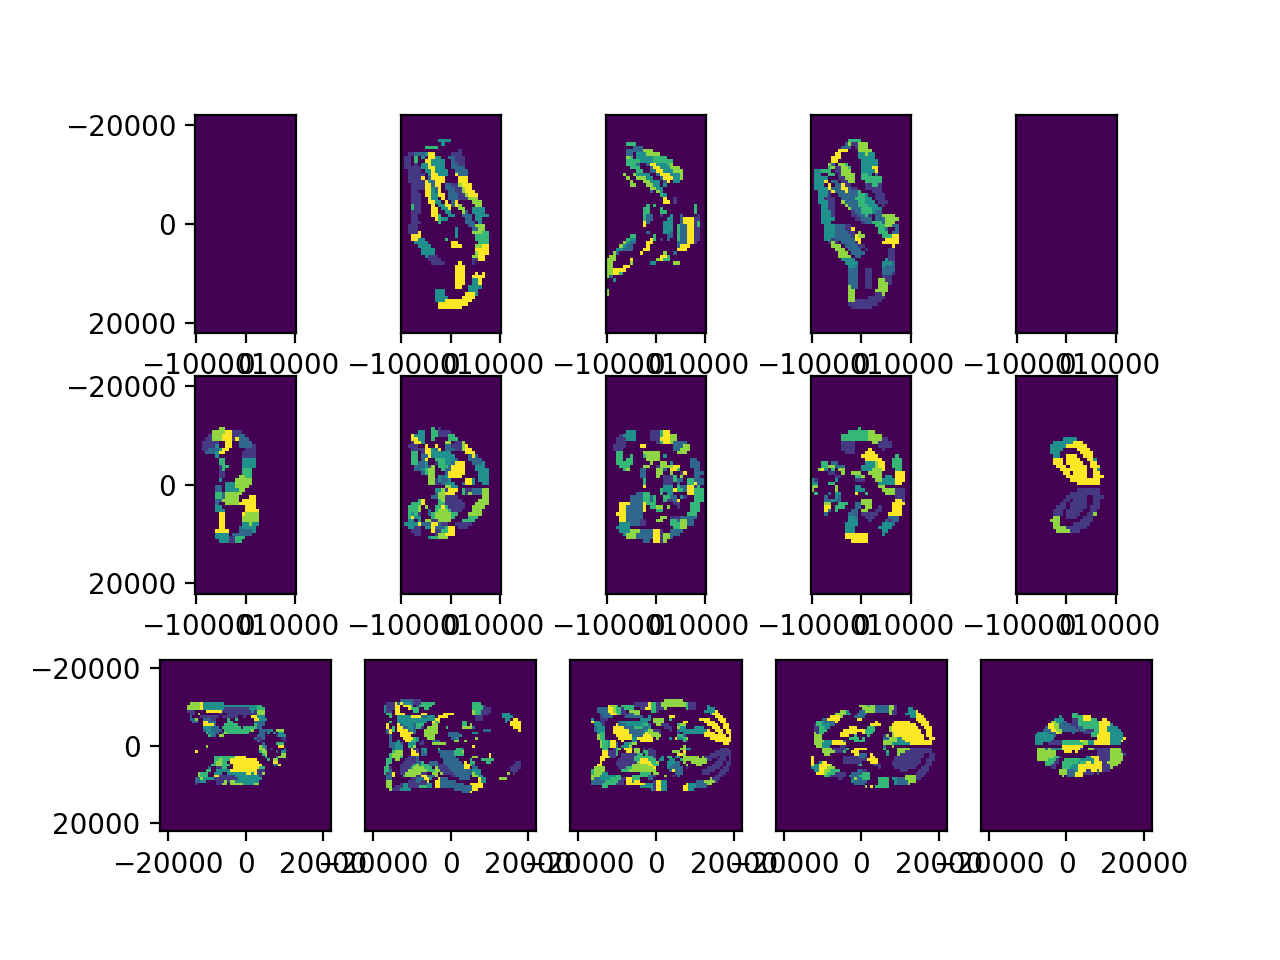

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f2922252990>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f28cfe29c50>]])

In [82]:
emlddmm.draw(It,xJ)
emlddmm.draw(St%7,xJ)

In [83]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [84]:
# write transformed images, these are at low res
imp.reload(emlddmm)
ext = output_image_format
if ext[0] != '.': ext = '.' + ext
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas'+ext),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target'+ext),xI,It,'atlas_to_target')
emlddmm.write_data(os.path.join(target_output_dir,'atlas_seg_to_target'+ext),xI,St,'atlas_seg_to_target')

Found extension .nii
Found extension .nii
Found extension .nii


/mnt/data/csh_data/emlddmm/emlddmm.py:1578: UserWarning: Writing image in nii fomat, no title or names saved
  warnings.warn('Writing image in nii fomat, no title or names saved')


Found extension .vtk
[ 39.999999  39.999999 112.000003]


<IPython.core.display.Javascript object>


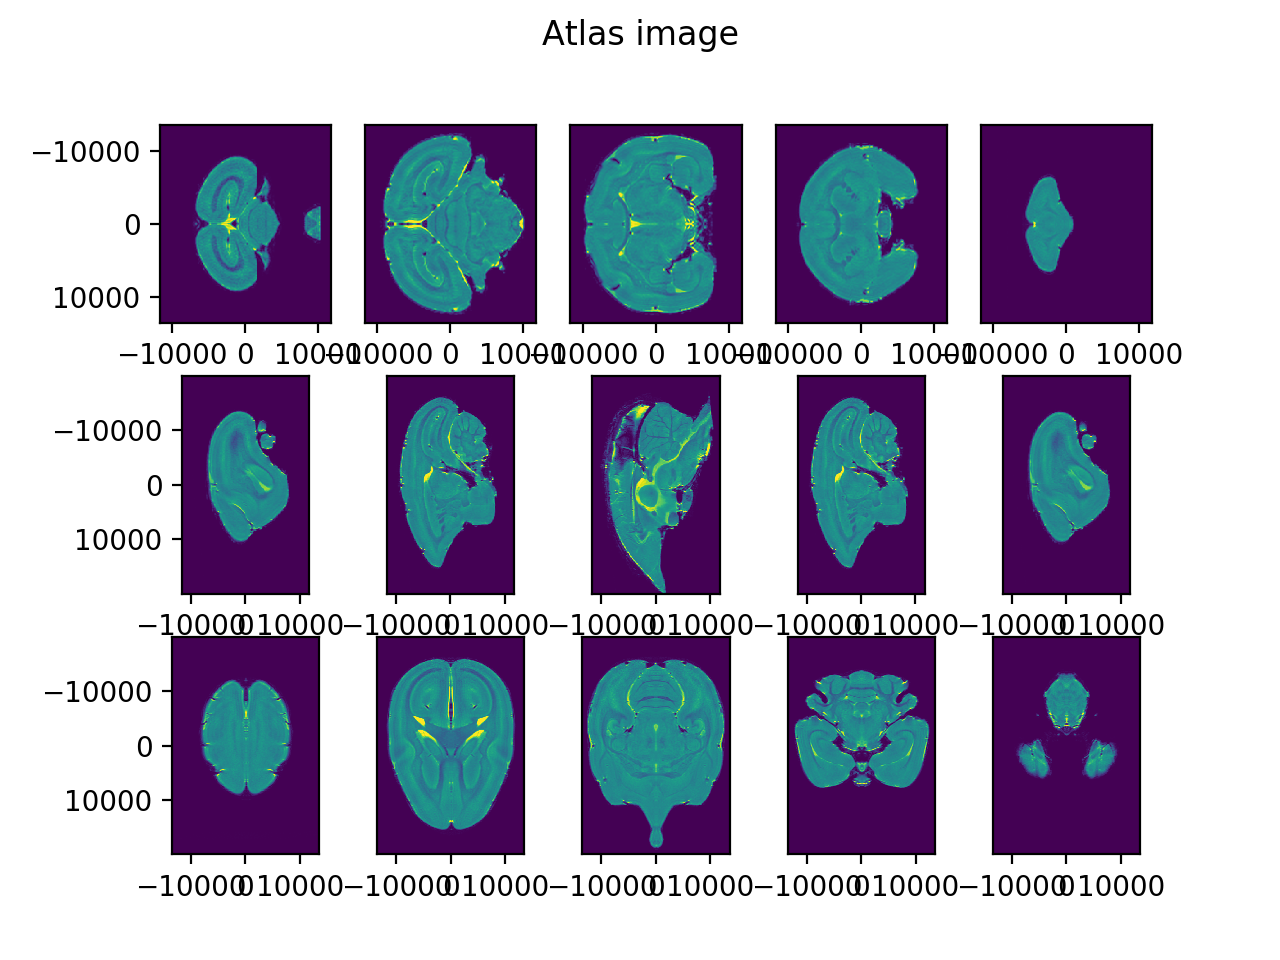

Found extension .nii
Opening with nibabel, note only 3D images supported
[349.99999404 349.99999404 699.99998808]


<IPython.core.display.Javascript object>


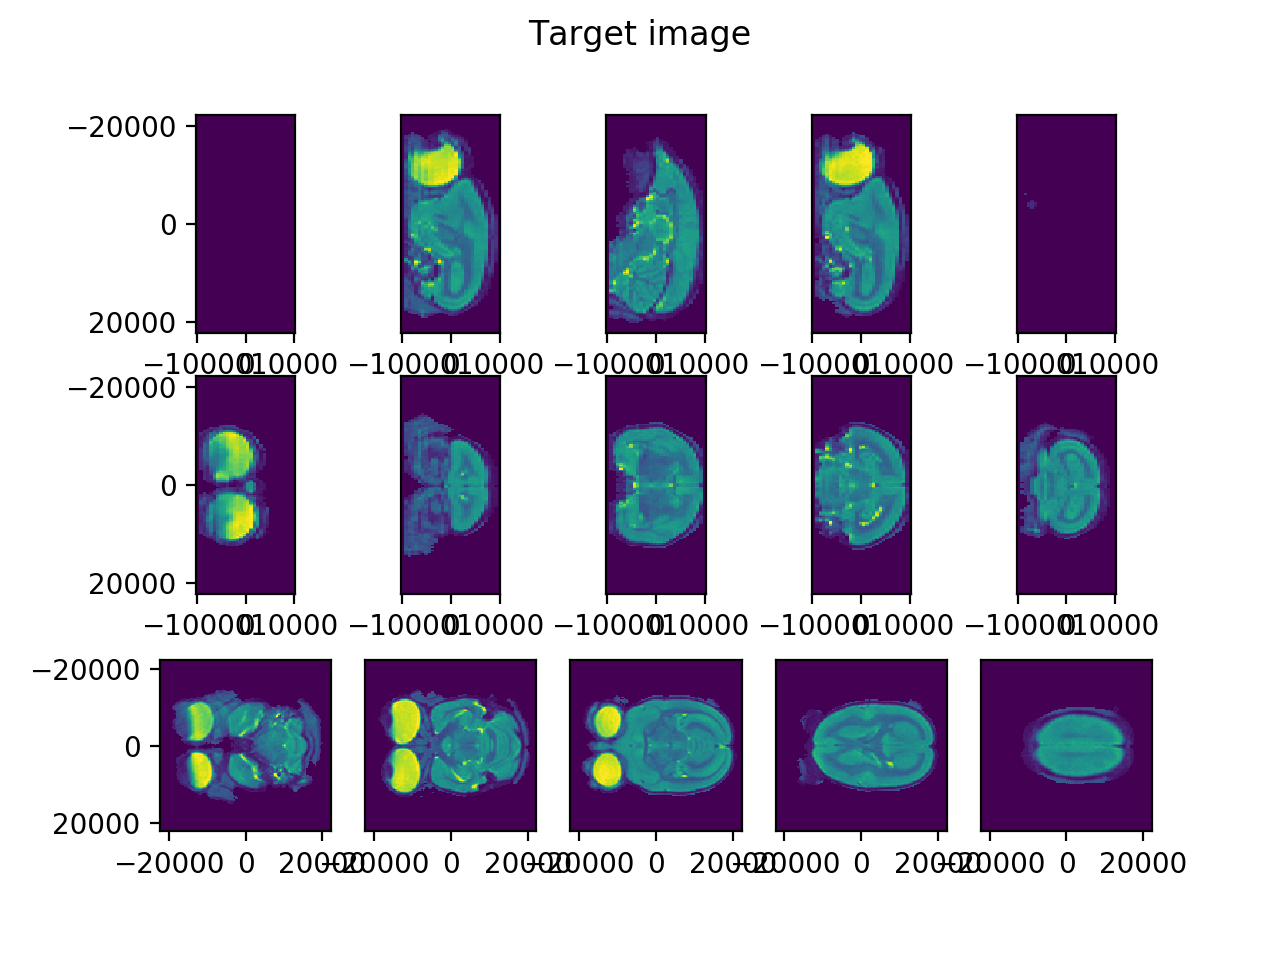

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


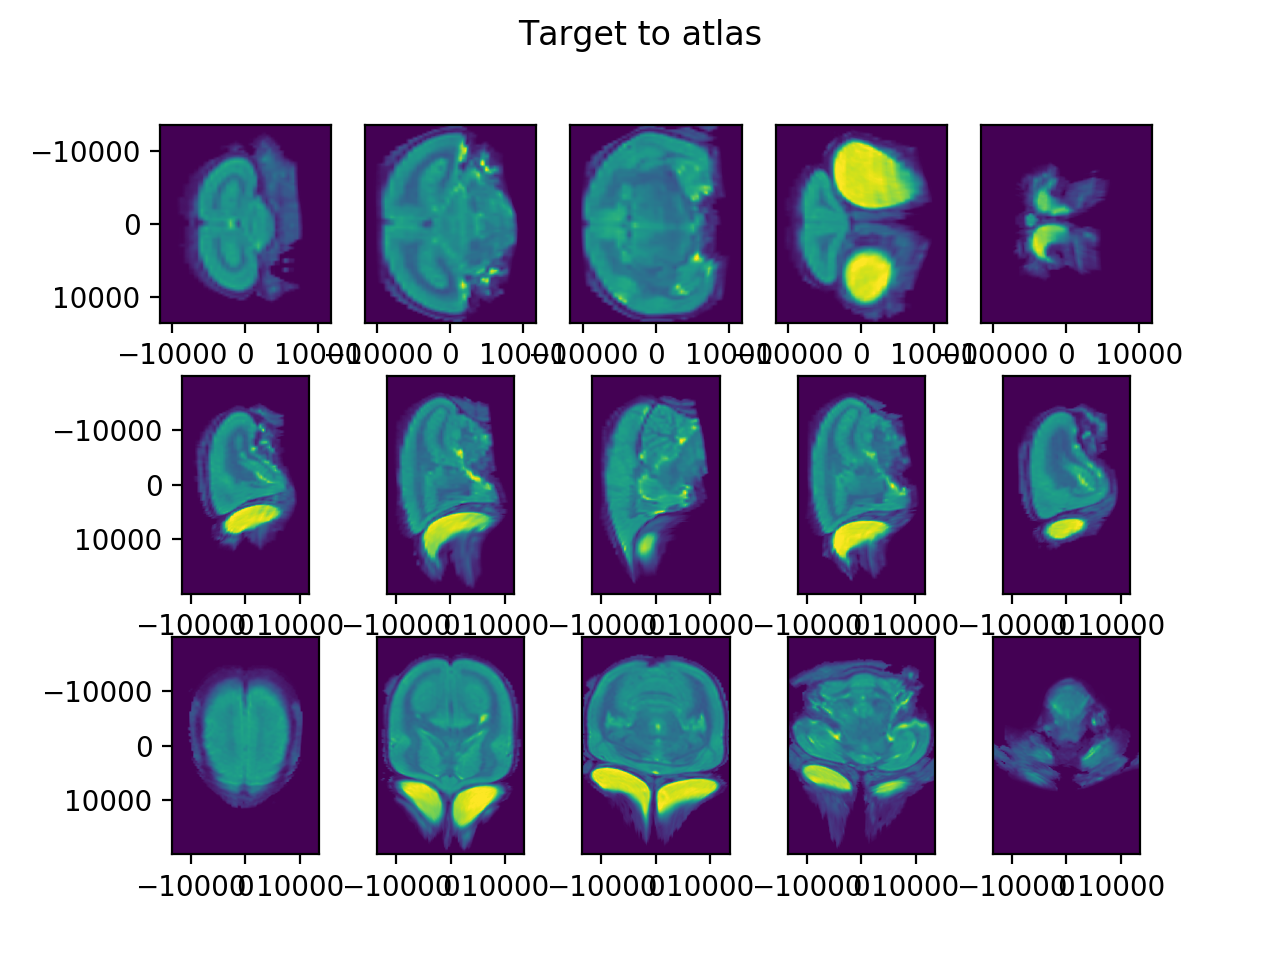

Found extension .nii
Found extension .nii
Opening with nibabel, note only 3D images supported
[349.99999404 349.99999404 699.99998808]


<IPython.core.display.Javascript object>


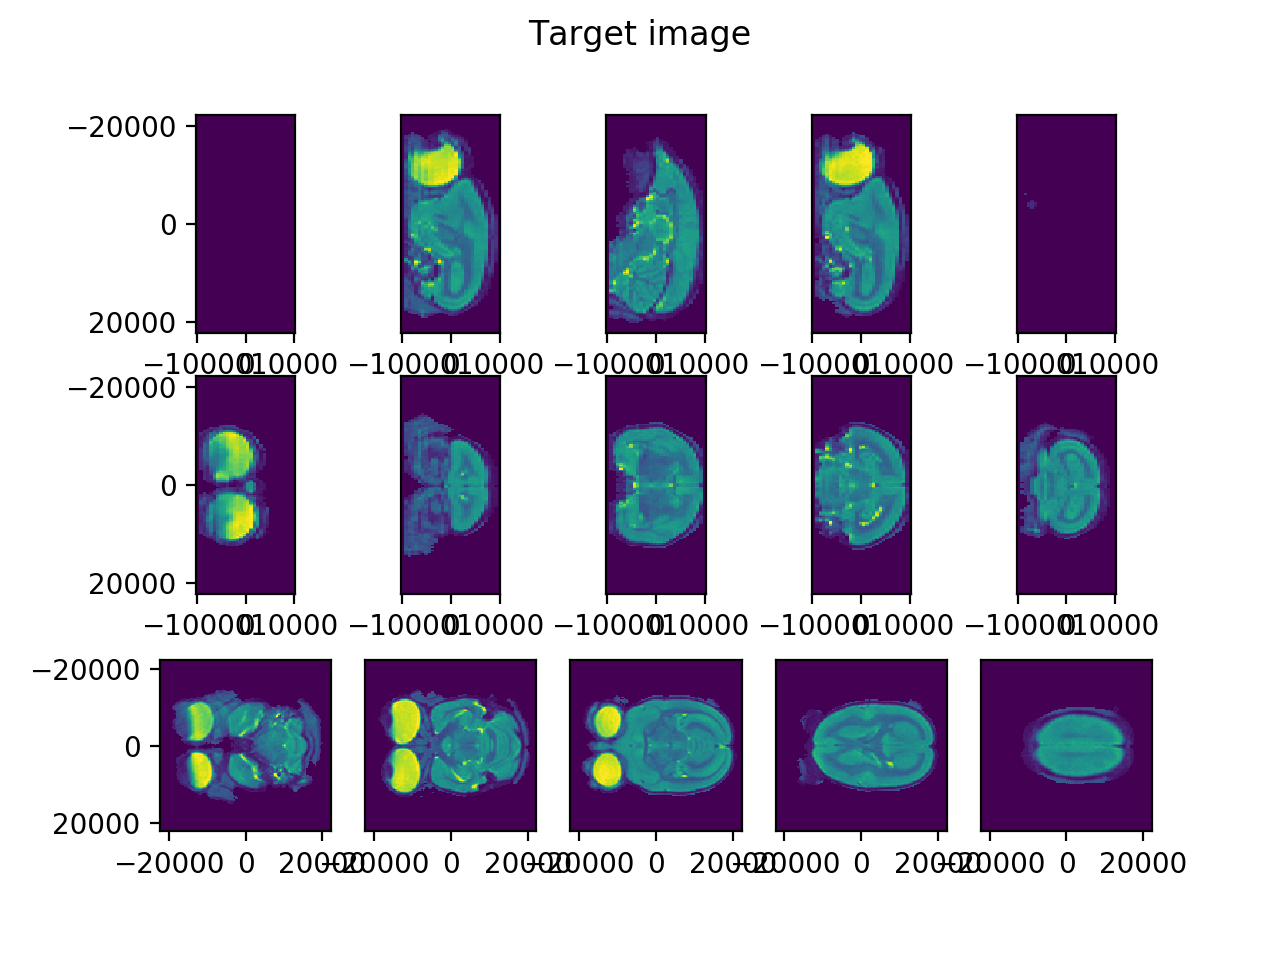

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


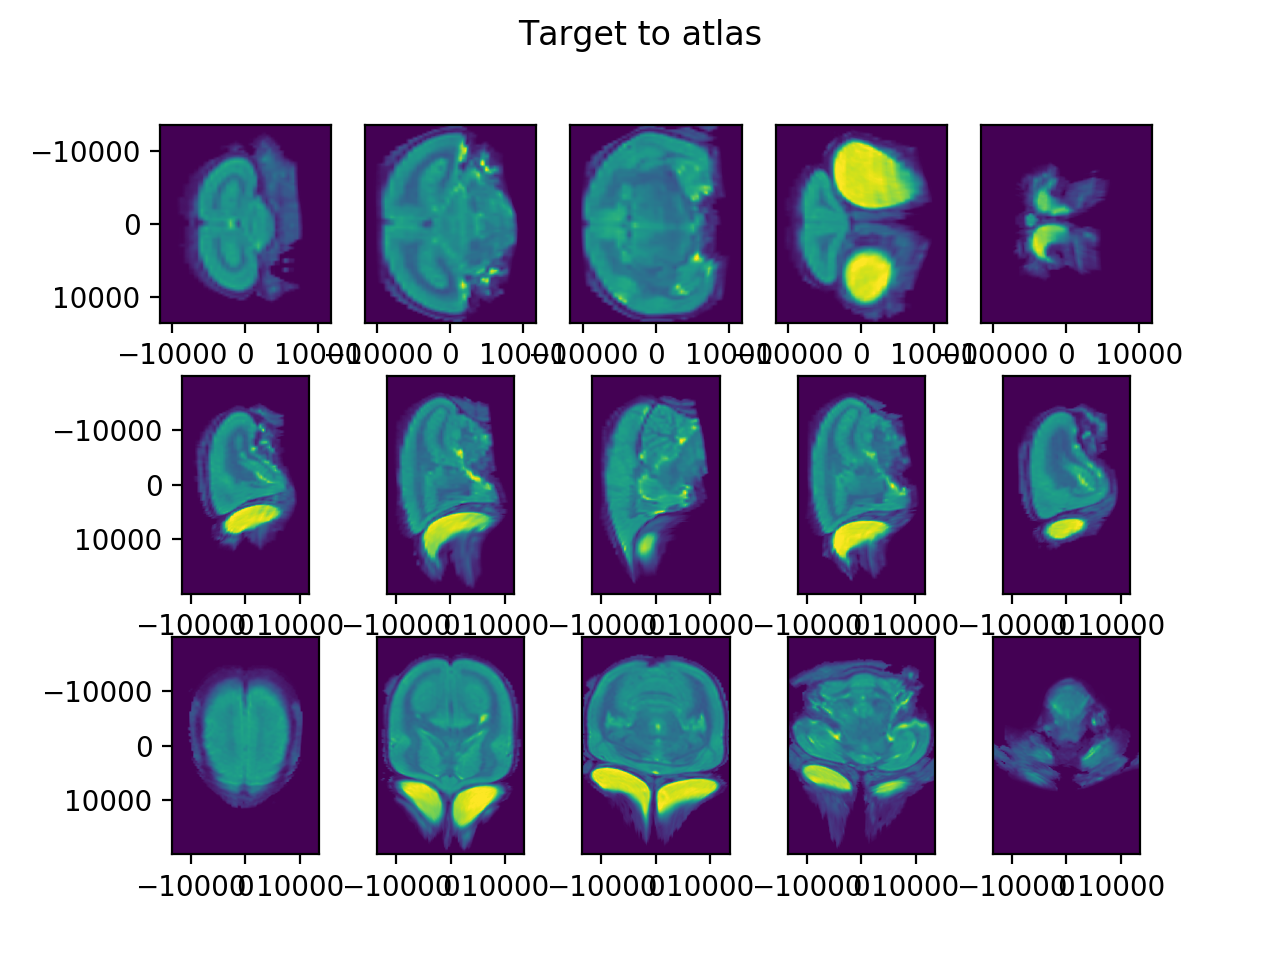

Found extension .nii
Found extension .nii
Opening with nibabel, note only 3D images supported
[349.99999404 349.99999404 699.99998808]


<IPython.core.display.Javascript object>


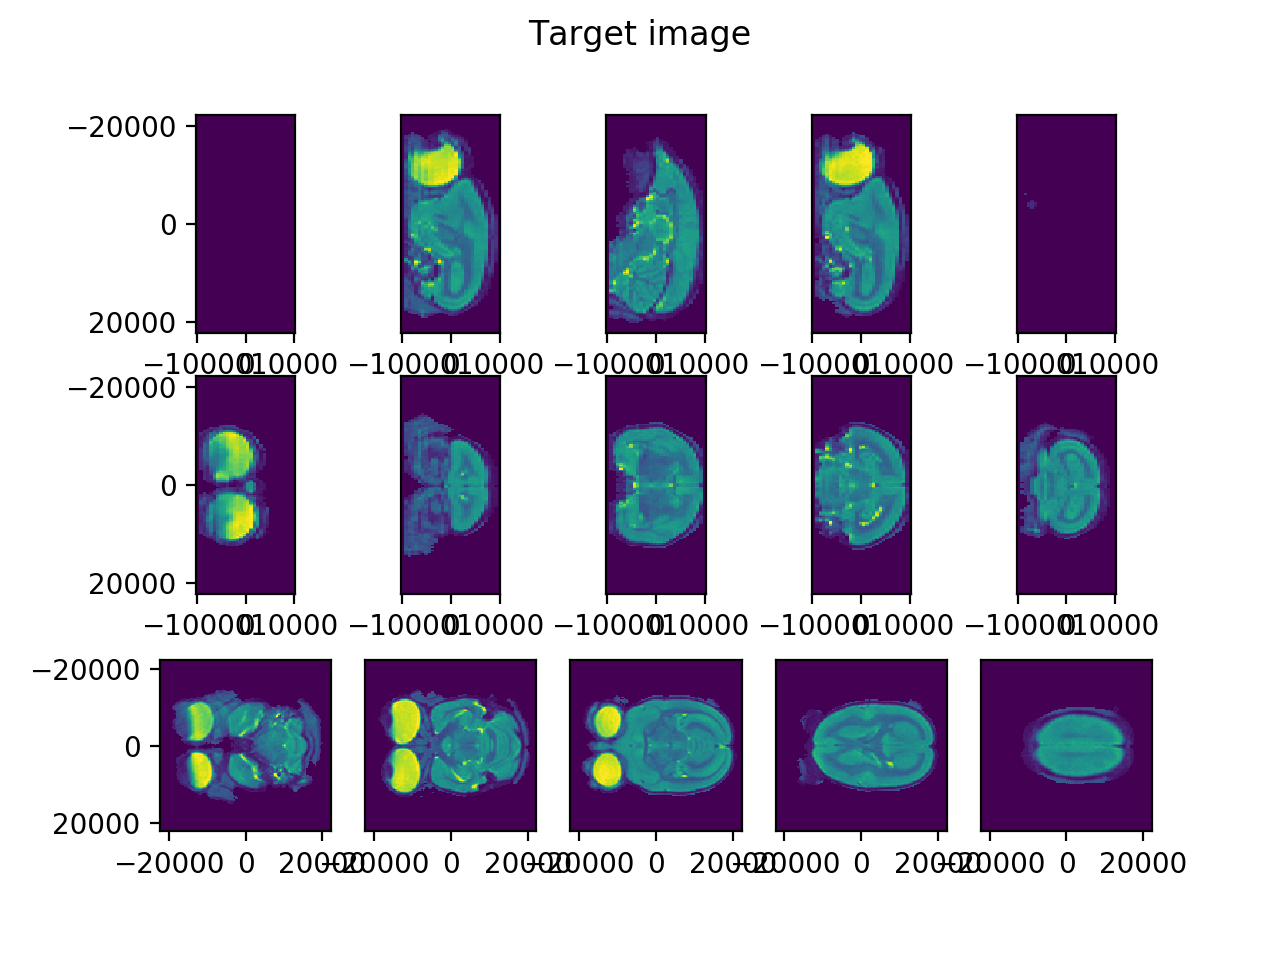

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


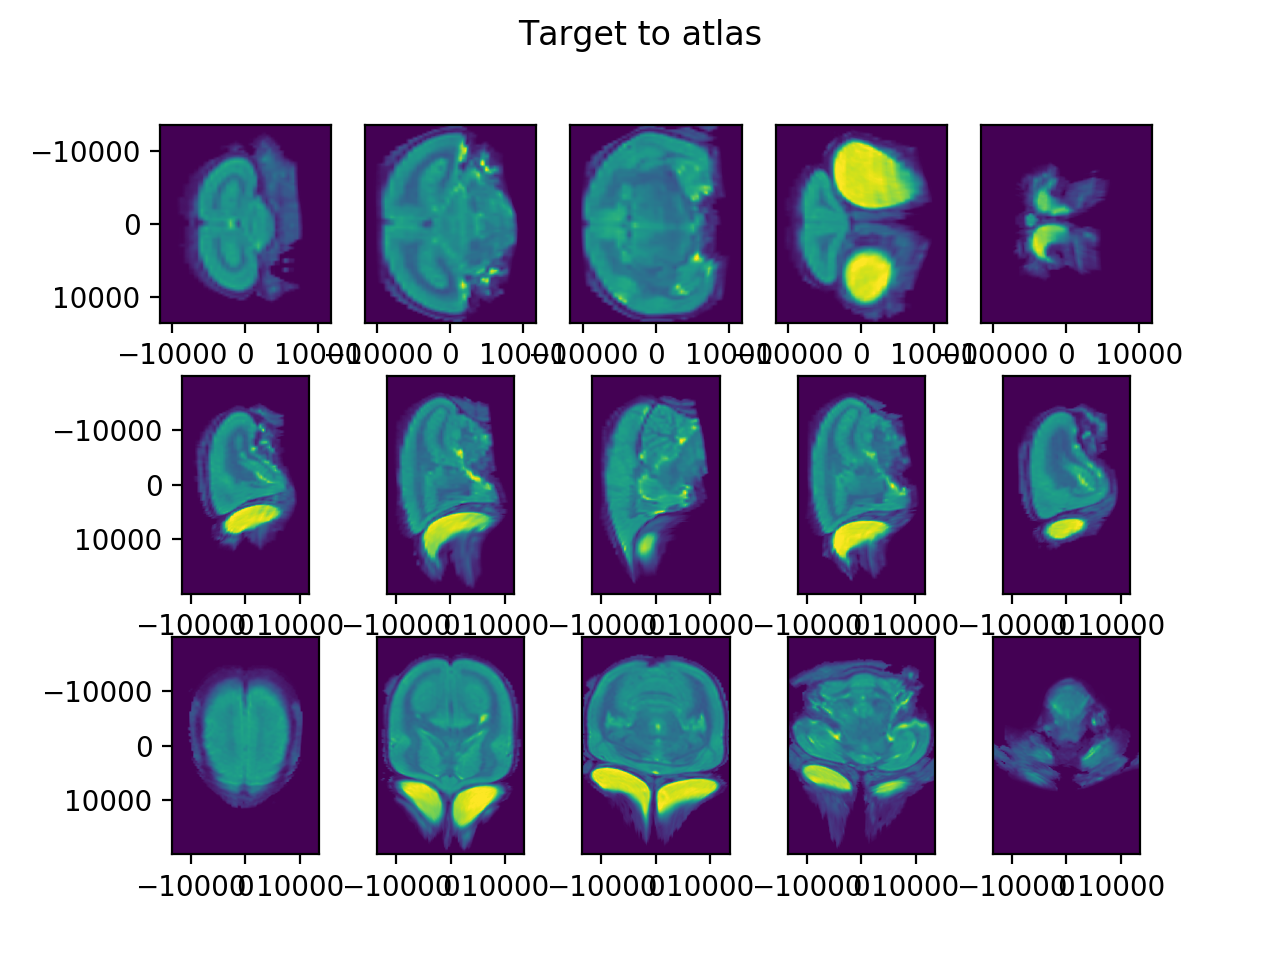

Found extension .nii


In [97]:
# reload atlas at full res 
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

# transform target images at full res
for fname in targets_to_transform_names:
    xJ,J,title,names = emlddmm.read_data(target_name)
    J = J.astype(float)
    J /= np.mean(np.abs(J))
    xJ = [x*target_voxel_scale_factor for x in xJ]
    dJ = np.array([x[1]-x[0] for x in xJ])
    print(dJ)
    J = J.astype(float)#**0.25
    fig = emlddmm.draw(J,xJ)
    fig[0].suptitle('Target image')
    
    Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
    Xout = emlddmm.compose_sequence(output_dir,Xin)
    Jt = emlddmm.apply_transform_float(xJ,J,Xout)

    fig = emlddmm.draw(Jt,xI)
    fig[0].suptitle('Target to atlas')
    
    # write out
    outname = os.path.splitext(os.path.split(fname)[1])[0]
    outname = os.path.join(atlas_output_dir,outname+ext)
    emlddmm.write_data(outname,xI,Jt,'target_to_atlas')